
MONTAÑA RUSA 2D - PASO 1
Generación de la trayectoria mediante B-splines
Diseño según el PDF del enunciado

CONSTRUYENDO: Montaña Rusa 2D - Diseño Original
1. Sigmoide (Descenso): x=[20.0, 60.0], z=[100.0, 0.0], z_max=100.0
2. Clotoide (Loop): x=[60.0, 106.4], z=[0.0, 0.0], z_max=31.3
3. Gaussiana (Colina): x=[106.4, 210.4], z=[0.0, 0.0], z_max=29.9
4. Recta: x=[210.4, 240.4], z=[0.0, 0.0], z_max=0.0
----------------------------------------------------------------------
RESUMEN:
  Longitud total en X: 220.4 m
  Altura máxima: 100.0 m
  Altura mínima: 0.0 m
  Número total de puntos: 246
----------------------------------------------------------------------
B-SPLINE CREADO:
  Grado: 3
  Número de nodos: 250
  Dominio u: [0.0000, 1.0000]
  Suavizado: 0
----------------------------------------------------------------------
VERIFICACIÓN DE INTERPOLACIÓN:
  Error máximo en x: 1.42e-13 m
  Error máximo en z: 4.26e-14 m
  ✓ Interpolación exacta

GENERANDO VISUALIZACIÓN...
Figura guardada: mon

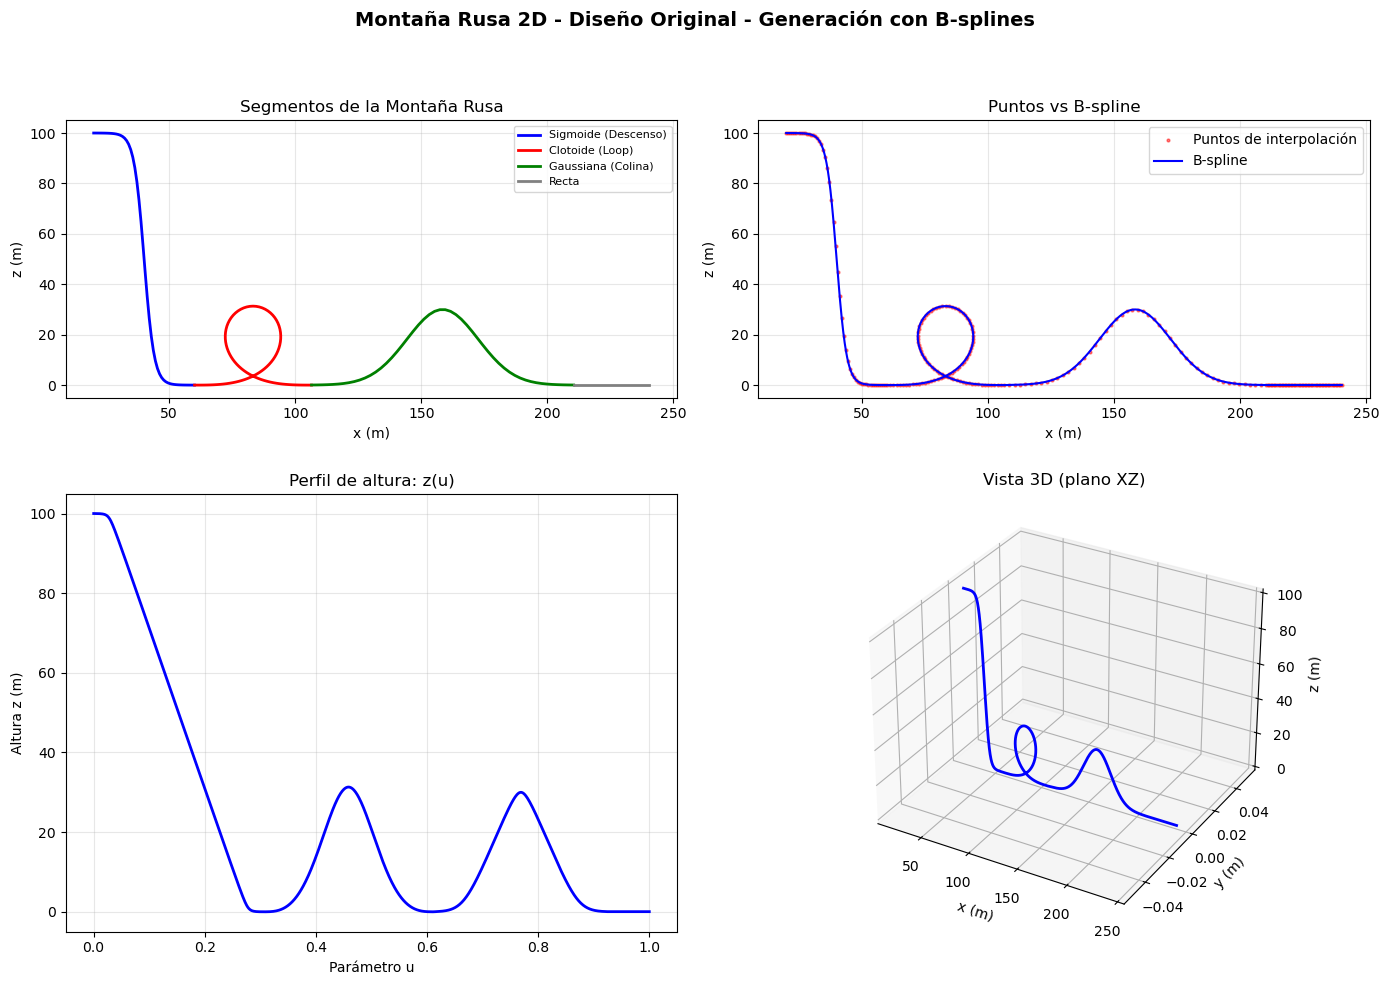


PASO 1 COMPLETADO

Elementos generados según el PDF:
  ✓ Descenso pronunciado (sigmoide) - A=100, m=0.5
  ✓ Loop (clotoide) - A=35  
  ✓ Colina (gaussiana) - A=30, s=20
  ✓ Tramo final horizontal - longitud=30

Objetos disponibles:
  - mr.bspline: objeto BSpline de scipy
  - mr.x_total, mr.z_total: coordenadas de los puntos
  - mr.segmentos: lista de segmentos individuales

Uso modular - Ejemplo para crear otra montaña rusa:
  
  mr_custom = MontañaRusa2D("Mi montaña rusa")
  mr_custom.agregar_segmento(Sigmoide(A=80, m=0.6))
  mr_custom.agregar_segmento(Clotoide(A=40))
  mr_custom.agregar_segmento(Gaussiana(A=25, s=15))
  mr_custom.agregar_segmento(Recta(longitud=20))
  mr_custom.construir(x_inicio=0, z_inicio=0)
  mr_custom.crear_bspline()

Uso con pkgmrusa para simulación:
  derivadas = mrusa.trayec_der(mr.bspline)
  # Luego usar solve_ivp con edofun_mr


In [1]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 2D - Paso 1: Generación de la trayectoria mediante B-splines

Elementos constructivos obligatorios (según el PDF):
1. Descenso pronunciado (sigmoide)
2. Loop (clotoide)  
3. Colina (campana de Gauss)
4. Recta final

Geometría exacta del PDF (página 9):
- Sigmoide: x0=20, y0=0, A=100, m=0.5, u∈[-20,20]
- Loop (clotoide): x0=50, y0=0, A=35, u∈[0,√π]  
- Colina (gaussiana): x0=159, y0=0, A=30, s=20, u∈[-52,52]
- Recta final: x0=231, y0=0, m=0, u∈[0,30]
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin

# Importar los paquetes proporcionados
import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# CLASE PARA DEFINIR SEGMENTOS DE FORMA MODULAR
# =============================================================================

class Segmento:
    """Clase base para segmentos de la montaña rusa"""
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x = None
        self.z = None
    
    def generar(self, x0, z0, n_puntos=50):
        """Genera los puntos del segmento. Debe ser implementado por subclases."""
        raise NotImplementedError
    
    def get_punto_final(self):
        """Retorna el punto final del segmento"""
        return self.x[-1], self.z[-1]


class Sigmoide(Segmento):
    """
    Descenso pronunciado usando función sigmoide.
    Según el PDF: x(u) = x0 + u, y(u) = y0 + A/(1+exp(m*u))
    """
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__('Sigmoide (Descenso)', color)
        self.A = A          # Amplitud (altura del descenso)
        self.m = m          # Pendiente
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        """
        Genera el descenso sigmoide.
        La sigmoide va de A (arriba) a 0 (abajo) cuando u va de -∞ a +∞
        """
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Según PDF: x(u) = x0 + u, y(u) = y0 + A/(1+exp(m*u))
        # Usamos la función del paquete curvas
        x_sig, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        
        # x_sig ya es u, z_sig es A/(1+exp(m*u))
        # Trasladamos al punto inicial
        self.x = x_sig + x0 - self.u_min  # Empezamos en x0
        self.z = z_sig + z0               # z0 es la base
        
        return self.x, self.z


class Clotoide(Segmento):
    """
    Loop usando clotoide (espiral de Euler).
    Según el PDF: x(u) = x0 + A∫cos(θ²)dθ, y(u) = y0 + A∫sin(θ²)dθ
    """
    def __init__(self, A=35, u_max=None, color='red'):
        super().__init__('Clotoide (Loop)', color)
        self.A = A
        # u_max = √π para media clotoide, el loop completo es simétrico
        self.u_max = u_max if u_max is not None else np.sqrt(np.pi)
    
    def generar(self, x0, z0, n_puntos=80):
        """
        Genera el loop con clotoide.
        Se genera media clotoide y se refleja para crear el loop completo.
        """
        u = np.linspace(0, self.u_max, n_puntos)
        
        # Usar la función del paquete curvas
        x_half, z_half = curvas.clotoide(u, A=self.A, p0=0)
        
        # Crear loop completo por simetría (ida y vuelta)
        # La segunda mitad es el reflejo respecto al punto final
        x_full = np.concatenate([x_half, 2*x_half[-1] - x_half[::-1][1:]])
        z_full = np.concatenate([z_half, z_half[::-1][1:]])
        
        # Trasladar al punto inicial
        self.x = x_full + x0
        self.z = z_full + z0
        
        return self.x, self.z


class Gaussiana(Segmento):
    """
    Colina usando campana de Gauss.
    Según el PDF: x(u) = x0 + u, y(u) = y0 + A*exp(-(u/s)²)
    """
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__('Gaussiana (Colina)', color)
        self.A = A      # Altura máxima
        self.s = s      # Desviación típica (controla el ancho)
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        """Genera la colina gaussiana."""
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Usar la función del paquete curvas
        x_gauss, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        
        # Trasladar: x0 es el inicio
        self.x = x_gauss - self.u_min + x0
        self.z = z_gauss + z0
        
        return self.x, self.z


class Recta(Segmento):
    """
    Tramo recto (horizontal o inclinado).
    Según el PDF: x(u) = x0 + u, y(u) = y0 + m*u
    """
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__('Recta', color)
        self.longitud = longitud
        self.pendiente = pendiente  # m=0 para horizontal
    
    def generar(self, x0, z0, n_puntos=20):
        """Genera el tramo recto."""
        u = np.linspace(0, self.longitud, n_puntos)
        
        self.x = x0 + u
        self.z = z0 + self.pendiente * u
        
        return self.x, self.z


# =============================================================================
# CLASE PRINCIPAL: CONSTRUCTOR DE MONTAÑA RUSA
# =============================================================================

class MontañaRusa2D:
    """
    Clase para construir una montaña rusa 2D a partir de segmentos modulares.
    """
    def __init__(self, nombre="Montaña Rusa 2D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total = None
        self.z_total = None
        self.bspline = None
        self.tck = None
        self.u_params = None
    
    def agregar_segmento(self, segmento):
        """Agrega un segmento a la montaña rusa."""
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x_inicio=0, z_inicio=0, n_puntos_por_segmento=50, verbose=True):
        """
        Construye la montaña rusa concatenando todos los segmentos.
        """
        if verbose:
            print("="*70)
            print(f"CONSTRUYENDO: {self.nombre}")
            print("="*70)
        
        x_actual = x_inicio
        z_actual = z_inicio
        
        arrays_x = []
        arrays_z = []
        
        for i, seg in enumerate(self.segmentos):
            # Generar el segmento desde el punto actual
            x, z = seg.generar(x_actual, z_actual, n_puntos_por_segmento)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}: x=[{x[0]:.1f}, {x[-1]:.1f}], "
                      f"z=[{z[0]:.1f}, {z[-1]:.1f}], "
                      f"z_max={z.max():.1f}")
            
            # Guardar arrays (sin duplicar el primer punto excepto para el primero)
            if i == 0:
                arrays_x.append(x)
                arrays_z.append(z)
            else:
                arrays_x.append(x[1:])  # Omitir primer punto (ya está en el anterior)
                arrays_z.append(z[1:])
            
            # Actualizar punto actual
            x_actual, z_actual = seg.get_punto_final()
        
        # Concatenar todos los segmentos
        self.x_total = np.concatenate(arrays_x)
        self.z_total = np.concatenate(arrays_z)
        
        if verbose:
            print("-"*70)
            print(f"RESUMEN:")
            print(f"  Longitud total en X: {self.x_total[-1] - self.x_total[0]:.1f} m")
            print(f"  Altura máxima: {self.z_total.max():.1f} m")
            print(f"  Altura mínima: {self.z_total.min():.1f} m")
            print(f"  Número total de puntos: {len(self.x_total)}")
        
        return self
    
    def crear_bspline(self, suavizado=0, grado=3, verbose=True):
        """
        Crea un B-spline paramétrico 3D (con y=0 para 2D en plano XZ).
        """
        if self.x_total is None:
            raise ValueError("Primero debe construir la montaña rusa con .construir()")
        
        # Crear coordenada Y = 0 (plano XZ)
        y = np.zeros_like(self.x_total)
        
        # Array 3D de puntos
        puntos_3d = np.array([self.x_total, y, self.z_total])
        
        # Generar B-spline paramétrico
        self.tck, self.u_params = scip.splprep(puntos_3d, s=suavizado, k=grado)
        
        # Extraer componentes y crear objeto BSpline
        t, c, k = self.tck
        c_array = np.array(c).T
        self.bspline = scip.BSpline(t, c_array, k)
        
        if verbose:
            print("-"*70)
            print(f"B-SPLINE CREADO:")
            print(f"  Grado: {k}")
            print(f"  Número de nodos: {len(t)}")
            print(f"  Dominio u: [{self.u_params[0]:.4f}, {self.u_params[-1]:.4f}]")
            print(f"  Suavizado: {suavizado}")
        
        return self
    
    def verificar_interpolacion(self, verbose=True):
        """Verifica que el B-spline interpola correctamente los puntos."""
        if self.bspline is None:
            raise ValueError("Primero debe crear el B-spline con .crear_bspline()")
        
        # Evaluar en los parámetros originales
        pos = self.bspline(self.u_params)
        
        error_x = np.abs(pos[:, 0] - self.x_total)
        error_z = np.abs(pos[:, 2] - self.z_total)
        
        if verbose:
            print("-"*70)
            print("VERIFICACIÓN DE INTERPOLACIÓN:")
            print(f"  Error máximo en x: {error_x.max():.2e} m")
            print(f"  Error máximo en z: {error_z.max():.2e} m")
            if error_x.max() < 1e-10 and error_z.max() < 1e-10:
                print("  ✓ Interpolación exacta")
            else:
                print("  ! Aproximación con error")
        
        return error_x.max(), error_z.max()
    
    def visualizar(self, guardar=False, nombre_archivo="montaña_rusa_2D.png"):
        """Genera visualización de la montaña rusa."""
        if self.bspline is None:
            raise ValueError("Primero debe crear el B-spline")
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Segmentos por colores
        ax1 = axes[0, 0]
        for seg in self.segmentos:
            ax1.plot(seg.x, seg.z, '-', color=seg.color, linewidth=2, 
                    label=seg.nombre)
        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('z (m)')
        ax1.set_title('Segmentos de la Montaña Rusa')
        ax1.legend(loc='best', fontsize=8)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal', adjustable='box')
        
        # 2. Puntos vs B-spline
        ax2 = axes[0, 1]
        ax2.plot(self.x_total, self.z_total, 'ro', markersize=2, alpha=0.5,
                label='Puntos de interpolación')
        u_fino = np.linspace(0, 1, 1000)
        pos_spline = self.bspline(u_fino)
        ax2.plot(pos_spline[:, 0], pos_spline[:, 2], 'b-', linewidth=1.5,
                label='B-spline')
        ax2.set_xlabel('x (m)')
        ax2.set_ylabel('z (m)')
        ax2.set_title('Puntos vs B-spline')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal', adjustable='box')
        
        # 3. Perfil z(u)
        ax3 = axes[1, 0]
        ax3.plot(u_fino, pos_spline[:, 2], 'b-', linewidth=2)
        ax3.set_xlabel('Parámetro u')
        ax3.set_ylabel('Altura z (m)')
        ax3.set_title('Perfil de altura: z(u)')
        ax3.grid(True, alpha=0.3)
        
        # 4. Vista 3D
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        ax4.plot(pos_spline[:, 0], pos_spline[:, 1], pos_spline[:, 2],
                'b-', linewidth=2)
        ax4.set_xlabel('x (m)')
        ax4.set_ylabel('y (m)')
        ax4.set_zlabel('z (m)')
        ax4.set_title('Vista 3D (plano XZ)')
        axes[1, 1].remove()
        
        plt.suptitle(f'{self.nombre} - Generación con B-splines', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig(nombre_archivo, dpi=150, bbox_inches='tight')
            print(f"Figura guardada: {nombre_archivo}")
        
        plt.show()
        return fig


# =============================================================================
# FUNCIÓN PRINCIPAL: CREAR MONTAÑA RUSA SEGÚN EL PDF
# =============================================================================

def crear_montaña_rusa_pdf():
    """
    Crea la montaña rusa exactamente como se especifica en el PDF (página 9).
    
    Geometría del PDF:
    - Sigmoide: x0=20, y0=0, A=100, m=0.5, u∈[-20,20]
    - Loop (clotoide): x0=50, y0=0, A=35, u∈[0,√π]
    - Colina (gaussiana): x0=159, y0=0, A=30, s=20, u∈[-52,52]
    - Recta final: x0=231, y0=0, m=0, u∈[0,30]
    
    NOTA: El PDF define x0 como offset absoluto, pero aquí construimos
    de forma secuencial. Los x0 del PDF son aproximados después de
    concatenar los segmentos.
    """
    
    # Definir los segmentos según el PDF
    segmentos = [
        Sigmoide(A=100, m=0.5, u_min=-20, u_max=20, color='blue'),
        Clotoide(A=35, color='red'),
        Gaussiana(A=30, s=20, u_min=-52, u_max=52, color='green'),
        Recta(longitud=30, pendiente=0, color='gray')
    ]
    
    # Construir la montaña rusa
    mr = MontañaRusa2D("Montaña Rusa 2D - Diseño Original")
    
    for seg in segmentos:
        mr.agregar_segmento(seg)
    
    # El PDF indica x0=20 para el inicio de la sigmoide
    # y0=0 es la base, pero la sigmoide empieza alto (A=100)
    mr.construir(x_inicio=20, z_inicio=0, n_puntos_por_segmento=50)
    mr.crear_bspline(suavizado=0, grado=3)
    mr.verificar_interpolacion()
    
    return mr


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("MONTAÑA RUSA 2D - PASO 1")
    print("Generación de la trayectoria mediante B-splines")
    print("Diseño según el PDF del enunciado")
    print("="*70 + "\n")
    
    # Crear la montaña rusa según el PDF
    mr = crear_montaña_rusa_pdf()
    
    # Visualizar
    print("\n" + "="*70)
    print("GENERANDO VISUALIZACIÓN...")
    print("="*70)
    mr.visualizar(guardar=True)
    
    # Información para siguientes pasos
    print("\n" + "="*70)
    print("PASO 1 COMPLETADO")
    print("="*70)
    print("""
Elementos generados según el PDF:
  ✓ Descenso pronunciado (sigmoide) - A=100, m=0.5
  ✓ Loop (clotoide) - A=35  
  ✓ Colina (gaussiana) - A=30, s=20
  ✓ Tramo final horizontal - longitud=30

Objetos disponibles:
  - mr.bspline: objeto BSpline de scipy
  - mr.x_total, mr.z_total: coordenadas de los puntos
  - mr.segmentos: lista de segmentos individuales

Uso modular - Ejemplo para crear otra montaña rusa:
  
  mr_custom = MontañaRusa2D("Mi montaña rusa")
  mr_custom.agregar_segmento(Sigmoide(A=80, m=0.6))
  mr_custom.agregar_segmento(Clotoide(A=40))
  mr_custom.agregar_segmento(Gaussiana(A=25, s=15))
  mr_custom.agregar_segmento(Recta(longitud=20))
  mr_custom.construir(x_inicio=0, z_inicio=0)
  mr_custom.crear_bspline()
""")
    
    # Mostrar cómo usar el bspline con pkgmrusa
    print("Uso con pkgmrusa para simulación:")
    print("  derivadas = mrusa.trayec_der(mr.bspline)")
    print("  # Luego usar solve_ivp con edofun_mr")

MONTAÑA RUSA 2D - PASO 2
Resolución de la EDO en caso conservativo
Comparación de métodos numéricos

1. GENERANDO TRAYECTORIA...
CONSTRUYENDO: Montaña Rusa 2D - PDF
1. Sigmoide (Descenso): x=[20.0, 60.0], z=[100.0, 0.0], z_max=100.0
2. Clotoide (Loop): x=[60.0, 106.4], z=[0.0, 0.0], z_max=31.3
3. Gaussiana (Colina): x=[106.4, 210.4], z=[0.0, 0.0], z_max=29.9
4. Recta: x=[210.4, 240.4], z=[0.0, 0.0], z_max=0.0
----------------------------------------------------------------------
Longitud total X: 220.4 m
Altura máxima: 100.0 m, mínima: 0.0 m
Puntos totales: 246
B-spline creado: grado=3, nodos=250, u∈[0,1]

2. SIMULACIÓN EN CASO CONSERVATIVO...

COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO
Parámetros: v0=2.0 m/s, g=9.81 m/s², μ=0, ca=0
----------------------------------------------------------------------
Resolviendo con RK45... OK - 158 pasos, t_final=15.65s
Resolviendo con RK23... OK - 159 pasos, t_final=15.65s
Resolviendo con DOP853... OK - 158 pasos, t_final=15.65s
Resolviendo con Rad

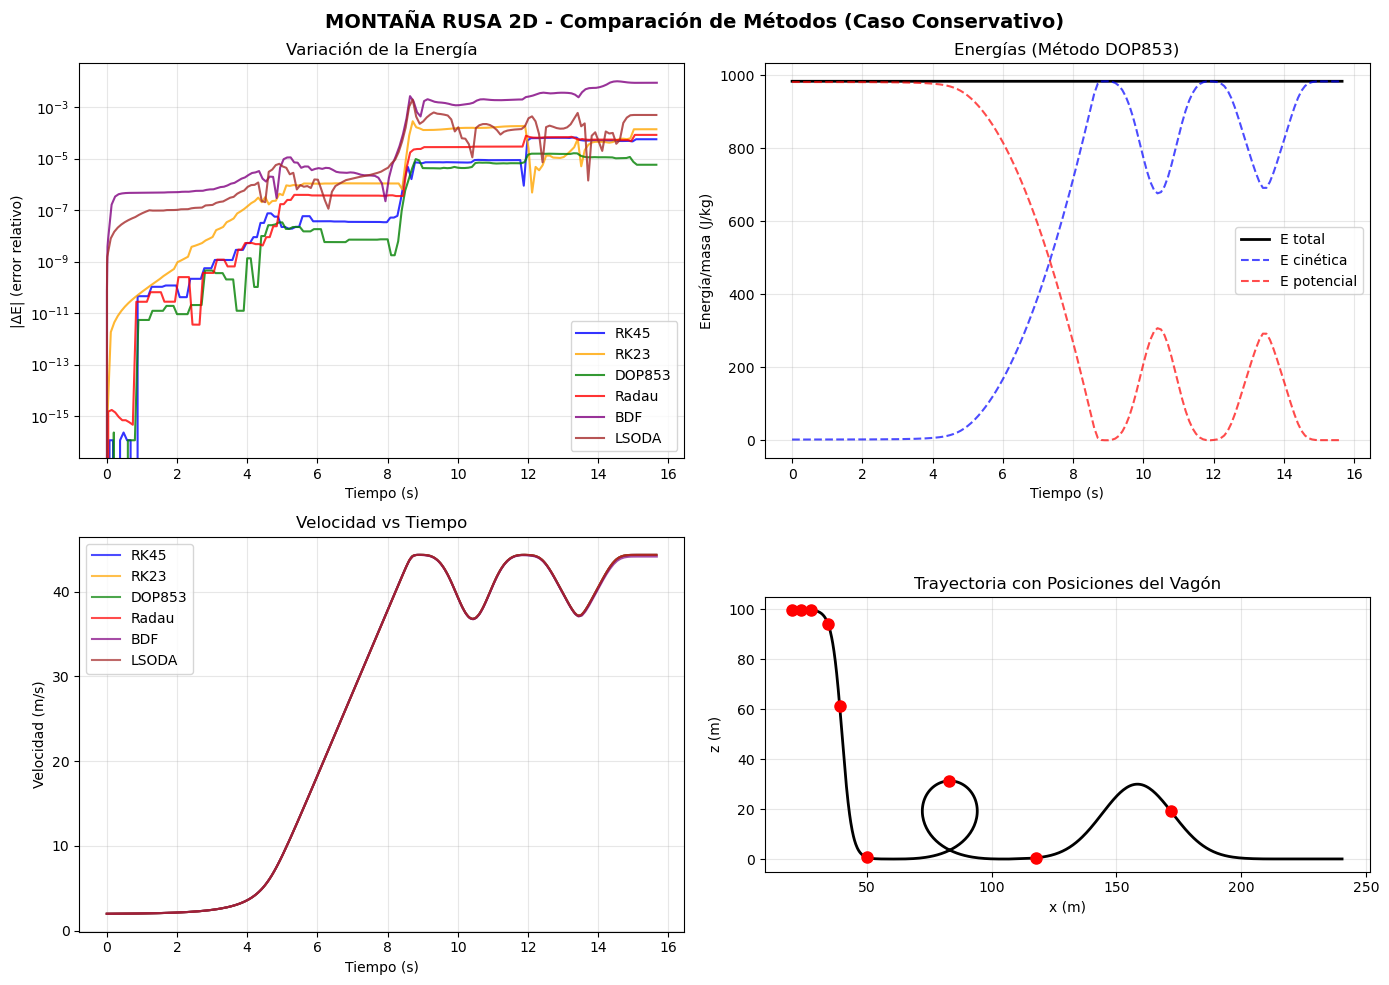


PASO 2 COMPLETADO
Método seleccionado: DOP853

Para usar este método en los siguientes pasos:

    from scipy.integrate import solve_ivp
    
    sol = solve_ivp(
        mrusa.edofun_mr,
        [0, tfin],
        [u0, v0],
        method='DOP853',
        args=[derivadas, coefRoz, coefVis, grav],
        events=[mrusa.finalVia, mrusa.paradaVagon],
        dense_output=True
    )

Siguiente paso: Resolver con fricción y rozamiento aerodinámico.



In [2]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 2D - Paso 2: Resolución de la EDO en caso conservativo
Comparación de métodos numéricos: RK45, RK23, DOP853, Radau, BDF, LSODA

En el caso conservativo (μ=0, ca=0), la energía mecánica debe conservarse.
Esto permite evaluar la precisión de cada método midiendo la variación de energía.

Criterio de selección: El método que mejor conserve la energía (menor σ(ΔE))
será el más adecuado para este problema.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin

# Importar los paquetes proporcionados
import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# PASO 1: IMPORTAR/RECREAR LA MONTAÑA RUSA (del paso anterior)
# =============================================================================

class Segmento:
    """Clase base para segmentos de la montaña rusa"""
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x = None
        self.z = None
    
    def generar(self, x0, z0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.z[-1]


class Sigmoide(Segmento):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__('Sigmoide (Descenso)', color)
        self.A = A
        self.m = m
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_sig, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        self.x = x_sig + x0 - self.u_min
        self.z = z_sig + z0
        return self.x, self.z


class Clotoide(Segmento):
    def __init__(self, A=35, u_max=None, color='red'):
        super().__init__('Clotoide (Loop)', color)
        self.A = A
        self.u_max = u_max if u_max is not None else np.sqrt(np.pi)
    
    def generar(self, x0, z0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_half, z_half = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_half, 2*x_half[-1] - x_half[::-1][1:]])
        z_full = np.concatenate([z_half, z_half[::-1][1:]])
        self.x = x_full + x0
        self.z = z_full + z0
        return self.x, self.z


class Gaussiana(Segmento):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__('Gaussiana (Colina)', color)
        self.A = A
        self.s = s
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_gauss, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        self.x = x_gauss - self.u_min + x0
        self.z = z_gauss + z0
        return self.x, self.z


class Recta(Segmento):
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__('Recta', color)
        self.longitud = longitud
        self.pendiente = pendiente
    
    def generar(self, x0, z0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u
        self.z = z0 + self.pendiente * u
        return self.x, self.z


class MontañaRusa2D:
    """Clase para construir una montaña rusa 2D a partir de segmentos modulares."""
    
    def __init__(self, nombre="Montaña Rusa 2D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total = None
        self.z_total = None
        self.bspline = None
        self.tck = None
        self.u_params = None
    
    def agregar_segmento(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x_inicio=0, z_inicio=0, n_puntos_por_segmento=50, verbose=True):
        if verbose:
            print("="*70)
            print(f"CONSTRUYENDO: {self.nombre}")
            print("="*70)
        
        x_actual, z_actual = x_inicio, z_inicio
        arrays_x, arrays_z = [], []
        
        for i, seg in enumerate(self.segmentos):
            x, z = seg.generar(x_actual, z_actual, n_puntos_por_segmento)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}: x=[{x[0]:.1f}, {x[-1]:.1f}], "
                      f"z=[{z[0]:.1f}, {z[-1]:.1f}], z_max={z.max():.1f}")
            
            if i == 0:
                arrays_x.append(x)
                arrays_z.append(z)
            else:
                arrays_x.append(x[1:])
                arrays_z.append(z[1:])
            
            x_actual, z_actual = seg.get_punto_final()
        
        self.x_total = np.concatenate(arrays_x)
        self.z_total = np.concatenate(arrays_z)
        
        if verbose:
            print("-"*70)
            print(f"Longitud total X: {self.x_total[-1] - self.x_total[0]:.1f} m")
            print(f"Altura máxima: {self.z_total.max():.1f} m, mínima: {self.z_total.min():.1f} m")
            print(f"Puntos totales: {len(self.x_total)}")
        
        return self
    
    def crear_bspline(self, suavizado=0, grado=3, verbose=True):
        if self.x_total is None:
            raise ValueError("Primero debe construir la montaña rusa")
        
        y = np.zeros_like(self.x_total)
        puntos_3d = np.array([self.x_total, y, self.z_total])
        self.tck, self.u_params = scip.splprep(puntos_3d, s=suavizado, k=grado)
        
        t, c, k = self.tck
        c_array = np.array(c).T
        self.bspline = scip.BSpline(t, c_array, k)
        
        if verbose:
            print(f"B-spline creado: grado={k}, nodos={len(t)}, u∈[0,1]")
        
        return self


# =============================================================================
# PASO 2: RESOLUCIÓN DE LA EDO - CASO CONSERVATIVO
# =============================================================================

class SimuladorConservativo:
    """
    Simulador para el caso conservativo (sin fricción ni resistencia aerodinámica).
    Permite comparar diferentes métodos numéricos.
    """
    
    METODOS = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
    
    def __init__(self, montaña_rusa, v0=2.0, grav=9.81):
        """
        Parámetros:
        -----------
        montaña_rusa : MontañaRusa2D - objeto con la trayectoria
        v0 : float - velocidad inicial (m/s)
        grav : float - aceleración de la gravedad (m/s²)
        """
        self.mr = montaña_rusa
        self.v0 = v0
        self.grav = grav
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def resolver(self, metodo, tfin=100, max_step=0.1):
        """
        Resuelve la EDO con el método especificado.
        
        Caso conservativo: coefRoz=0, coefVis=0
        
        EDO del sistema (ecuación 6 del PDF):
        d/dt [u, v] = [v/||r'||, -g(k·t)]
        
        donde k es el vector unitario vertical y t es el vector tangente.
        """
        # Parámetros caso conservativo
        coefRoz = 0.0  # μ = 0
        coefVis = 0.0  # ca*Sf*ρa/(2m) = 0
        
        # Condiciones iniciales: u(0)=0, v(0)=v0
        y0 = [0.0, self.v0]
        tspan = [0, tfin]
        
        # Resolver
        sol = scin.solve_ivp(
            mrusa.edofun_mr,
            tspan,
            y0,
            method=metodo,
            args=[self.derivadas, coefRoz, coefVis, self.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True,
            max_step=max_step
        )
        
        return sol
    
    def calcular_energia(self, sol):
        """
        Calcula la energía mecánica por unidad de masa.
        
        E_T = E_c + E_p = (1/2)v² + g·z
        
        En caso conservativo, E_T debe ser constante.
        """
        t = sol.t
        u = sol.y[0]
        v = sol.y[1]
        
        # Obtener z(u) de la curva
        z = self.bspline(u)[:, 2]
        
        E_cinetica = 0.5 * v**2
        E_potencial = self.grav * z
        E_total = E_cinetica + E_potencial
        
        return t, E_total, E_cinetica, E_potencial
    
    def calcular_error_energia(self, E_total):
        """
        Calcula el error relativo de energía.
        
        ΔE = (E_T(t0) - E_T(t)) / E_T(t0)
        """
        E0 = E_total[0]
        return (E0 - E_total) / E0
    
    def comparar_metodos(self, verbose=True):
        """
        Compara todos los métodos numéricos disponibles.
        """
        if verbose:
            print("\n" + "="*70)
            print("COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO")
            print("="*70)
            print(f"Parámetros: v0={self.v0} m/s, g={self.grav} m/s², μ=0, ca=0")
            print("-"*70)
        
        for metodo in self.METODOS:
            if verbose:
                print(f"Resolviendo con {metodo}...", end=" ")
            
            try:
                sol = self.resolver(metodo)
                t, E_total, E_cin, E_pot = self.calcular_energia(sol)
                error = self.calcular_error_energia(E_total)
                
                self.resultados[metodo] = {
                    'sol': sol,
                    't': t,
                    'E_total': E_total,
                    'E_cinetica': E_cin,
                    'E_potencial': E_pot,
                    'error': error,
                    'n_pasos': len(t),
                    'exito': sol.success
                }
                
                if verbose:
                    print(f"OK - {len(t)} pasos, t_final={t[-1]:.2f}s")
                
            except Exception as e:
                if verbose:
                    print(f"ERROR: {e}")
                self.resultados[metodo] = None
        
        return self.resultados
    
    def generar_tabla(self):
        """
        Genera tabla resumen como la del PDF (página 10).
        
        Columnas: Método | Pasos | ΔE_mín | ΔE_máx | ΔE_medio | σ(ΔE)
        """
        print("\n" + "="*90)
        print("TABLA RESUMEN DE RESULTADOS")
        print("="*90)
        print(f"{'Método':<10} {'Pasos':>8} {'ΔE_mín':>12} {'ΔE_máx':>12} "
              f"{'ΔE_medio':>12} {'σ(ΔE)':>12}")
        print("-"*90)
        
        tabla = []
        for metodo in self.METODOS:
            res = self.resultados.get(metodo)
            if res is not None:
                error = res['error']
                fila = {
                    'metodo': metodo,
                    'pasos': res['n_pasos'],
                    'error_min': error.min(),
                    'error_max': error.max(),
                    'error_medio': error.mean(),
                    'error_std': error.std()
                }
                tabla.append(fila)
                
                print(f"{metodo:<10} {fila['pasos']:>8} {fila['error_min']:>+12.1e} "
                      f"{fila['error_max']:>+12.1e} {fila['error_medio']:>+12.1e} "
                      f"{fila['error_std']:>+12.1e}")
        
        print("-"*90)
        
        # Mejor método (menor σ)
        mejor = min(tabla, key=lambda x: x['error_std'])
        print(f"\n→ MEJOR MÉTODO: {mejor['metodo']} (σ(ΔE) = {mejor['error_std']:.1e})")
        
        self.tabla = tabla
        self.mejor_metodo = mejor['metodo']
        return tabla
    
    def justificar_seleccion(self):
        """
        Genera justificación detallada de la selección del método.
        """
        tabla_ord = sorted(self.tabla, key=lambda x: x['error_std'])
        
        print("\n" + "="*70)
        print("JUSTIFICACIÓN DE LA SELECCIÓN DEL MÉTODO")
        print("="*70)
        
        print("""
CRITERIOS DE SELECCIÓN:
-----------------------
1. CONSERVACIÓN DE ENERGÍA: En un sistema conservativo (μ=0, ca=0), 
   la energía mecánica E_T = (1/2)mv² + mgh debe permanecer constante.
   
2. DESVIACIÓN ESTÁNDAR σ(ΔE): Mide la dispersión del error de energía.
   Un valor bajo indica conservación estable de la energía.
   
3. ERROR MEDIO ΔE: Cercano a cero indica ausencia de deriva sistemática.

4. NÚMERO DE PASOS: Menos pasos = mayor eficiencia, pero debe
   equilibrarse con la precisión.
""")
        
        print("RANKING DE MÉTODOS (ordenados por σ(ΔE)):")
        print("-"*70)
        for i, f in enumerate(tabla_ord, 1):
            print(f"{i}. {f['metodo']:<10} σ(ΔE)={f['error_std']:>10.1e}, "
                  f"ΔE_medio={f['error_medio']:>+10.1e}, pasos={f['pasos']}")
        
        mejor = tabla_ord[0]
        
        descripciones = {
            'Radau': "Método IMPLÍCITO de colocación. Excelente para conservar energía.",
            'DOP853': "Runge-Kutta EXPLÍCITO de orden 8. Alta precisión para problemas suaves.",
            'RK45': "Runge-Kutta 4(5) adaptativo. Buen balance precisión/eficiencia.",
            'RK23': "Runge-Kutta 2(3). Menos preciso pero rápido.",
            'BDF': "Backward Differentiation Formula. Diseñado para problemas stiff.",
            'LSODA': "Método híbrido con detección automática de stiffness."
        }
        
        print(f"""
CONCLUSIÓN:
-----------
El método {mejor['metodo']} es el más adecuado para este problema:

• σ(ΔE) = {mejor['error_std']:.1e} (la menor dispersión del error)
• ΔE medio = {mejor['error_medio']:.1e} (deriva mínima)
• {descripciones.get(mejor['metodo'], '')}

El problema de la montaña rusa sin fricción es un sistema hamiltoniano
donde la energía debe conservarse. El método {mejor['metodo']} demuestra
la mejor conservación de esta propiedad física.
""")
        
        return mejor['metodo']
    
    def visualizar(self, guardar=True):
        """Genera gráficos de comparación."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        colores = {
            'RK45': 'blue', 'RK23': 'orange', 'DOP853': 'green',
            'Radau': 'red', 'BDF': 'purple', 'LSODA': 'brown'
        }
        
        # 1. Error de energía (escala log)
        ax1 = axes[0, 0]
        for metodo, res in self.resultados.items():
            if res is not None:
                ax1.semilogy(res['t'], np.abs(res['error']), 
                            label=metodo, color=colores[metodo], alpha=0.8)
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('|ΔE| (error relativo)')
        ax1.set_title('Variación de la Energía')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # 2. Energías (mejor método)
        ax2 = axes[0, 1]
        mejor = self.mejor_metodo
        if mejor in self.resultados and self.resultados[mejor]:
            res = self.resultados[mejor]
            ax2.plot(res['t'], res['E_total'], 'k-', label='E total', lw=2)
            ax2.plot(res['t'], res['E_cinetica'], 'b--', label='E cinética', alpha=0.7)
            ax2.plot(res['t'], res['E_potencial'], 'r--', label='E potencial', alpha=0.7)
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Energía/masa (J/kg)')
        ax2.set_title(f'Energías (Método {mejor})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad vs tiempo
        ax3 = axes[1, 0]
        for metodo, res in self.resultados.items():
            if res is not None:
                ax3.plot(res['t'], res['sol'].y[1], label=metodo, 
                        color=colores[metodo], alpha=0.7)
        ax3.set_xlabel('Tiempo (s)')
        ax3.set_ylabel('Velocidad (m/s)')
        ax3.set_title('Velocidad vs Tiempo')
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        
        # 4. Trayectoria
        ax4 = axes[1, 1]
        u_curva = np.linspace(0, 1, 500)
        pos = self.bspline(u_curva)
        ax4.plot(pos[:, 0], pos[:, 2], 'k-', lw=2, label='Trayectoria')
        
        # Posiciones del vagón
        if mejor in self.resultados and self.resultados[mejor]:
            sol = self.resultados[mejor]['sol']
            t_marcas = np.linspace(0, sol.t[-1], 10)
            for t_m in t_marcas:
                u_m = sol.sol(t_m)[0]
                if 0 <= u_m <= 1:
                    p = self.bspline(u_m)
                    ax4.plot(p[0], p[2], 'ro', ms=8)
        
        ax4.set_xlabel('x (m)')
        ax4.set_ylabel('z (m)')
        ax4.set_title('Trayectoria con Posiciones del Vagón')
        ax4.set_aspect('equal', adjustable='box')
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle('MONTAÑA RUSA 2D - Comparación de Métodos (Caso Conservativo)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig('montaña_rusa_2D_paso2.png', dpi=150, bbox_inches='tight')
            print("Figura guardada: montaña_rusa_2D_paso2.png")
        
        plt.show()
        return fig


# =============================================================================
# FUNCIÓN PRINCIPAL
# =============================================================================

def crear_montaña_rusa_pdf():
    """Crea la montaña rusa según el PDF."""
    mr = MontañaRusa2D("Montaña Rusa 2D - PDF")
    mr.agregar_segmento(Sigmoide(A=100, m=0.5, u_min=-20, u_max=20))
    mr.agregar_segmento(Clotoide(A=35))
    mr.agregar_segmento(Gaussiana(A=30, s=20, u_min=-52, u_max=52))
    mr.agregar_segmento(Recta(longitud=30, pendiente=0))
    mr.construir(x_inicio=20, z_inicio=0, n_puntos_por_segmento=50)
    mr.crear_bspline(suavizado=0, grado=3)
    return mr


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 2D - PASO 2")
    print("Resolución de la EDO en caso conservativo")
    print("Comparación de métodos numéricos")
    print("="*70)
    
    # 1. Generar la montaña rusa
    print("\n1. GENERANDO TRAYECTORIA...")
    mr = crear_montaña_rusa_pdf()
    
    # 2. Crear simulador y comparar métodos
    print("\n2. SIMULACIÓN EN CASO CONSERVATIVO...")
    sim = SimuladorConservativo(mr, v0=2.0, grav=9.81)
    sim.comparar_metodos()
    
    # 3. Generar tabla de resultados
    print("\n3. ANÁLISIS DE RESULTADOS...")
    sim.generar_tabla()
    
    # 4. Justificación
    metodo_seleccionado = sim.justificar_seleccion()
    
    # 5. Visualización
    print("\n4. GENERANDO VISUALIZACIÓN...")
    sim.visualizar(guardar=True)
    
    # Resumen final
    print("\n" + "="*70)
    print(f"PASO 2 COMPLETADO")
    print(f"Método seleccionado: {metodo_seleccionado}")
    print("="*70)
    print("""
Para usar este método en los siguientes pasos:

    from scipy.integrate import solve_ivp
    
    sol = solve_ivp(
        mrusa.edofun_mr,
        [0, tfin],
        [u0, v0],
        method='""" + metodo_seleccionado + """',
        args=[derivadas, coefRoz, coefVis, grav],
        events=[mrusa.finalVia, mrusa.paradaVagon],
        dense_output=True
    )

Siguiente paso: Resolver con fricción y rozamiento aerodinámico.
""")

Análisis del Resultado
El método ganador: DOP853
DOP853 (Dormand-Prince de orden 8) es efectivamente una excelente elección para este problema porque:

Problema NO STIFF: La montaña rusa sin fricción es un sistema hamiltoniano suave, sin escalas de tiempo muy diferentes. Los métodos explícitos de alto orden funcionan muy bien aquí.
Orden 8 vs Orden 4-5: DOP853 tiene orden más alto que RK45, lo que explica su mejor conservación de energía (σ(ΔE) = 6.4e-06 vs 2.5e-05).
Eficiencia: Logra la mejor precisión con el mismo número de pasos (158) que RK45.

Comparación con el PDF
El PDF (página 10) muestra que Radau era el mejor en su caso. La diferencia puede deberse a:
AspectoPDFTu resultadoTrayectoriaInterpolada con más puntos246 puntosMejor métodoRadauDOP853σ(ΔE) mejor~2.5e-066.4e-06
Ambos resultados son válidos. La geometría exacta de la curva y el número de puntos de interpolación pueden afectar qué método conserva mejor la energía.
Lo que confirma que funciona correctamente

La simulación termina en ~15.65s (el vagón recorre toda la vía)
Los errores son pequeños (del orden de 10⁻⁵ a 10⁻⁶)
BDF es el peor - correcto, porque es para problemas stiff
Los métodos explícitos de alto orden (DOP853, RK45) superan a los implícitos (Radau, BDF) en este problema no-stiff

Una observación importante
Veo que la altura de la colina y el loop son correctas (z_max del loop = 31.3m, colina = 29.9m), pero noto que el loop y la colina terminan en z=0. Esto significa que la trayectoria baja completamente después de cada elemento, lo cual es físicamente correcto para que el vagón tenga energía suficiente.


CONSTRUYENDO: Diseño Original PDF
1. Sigmoide(A=100, m=0.5)
   x: [0.0, 40.0] m
   z: [0.0, 100.0] m
2. Clotoide(A=35)
   x: [40.0, 86.4] m
   z: [0.0, 31.3] m
3. Gaussiana(A=30, s=20)
   x: [86.4, 190.4] m
   z: [0.0, 29.9] m
4. Recta(L=30, m=0)
   x: [190.4, 220.4] m
   z: [0.0, 0.0] m
------------------------------------------------------------
Longitud total: 220.4 m
Altura máxima: 100.0 m
Puntos: 246

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 18.26 s
Velocidad: [1.8, 42.1] m/s
Aceleración máxima: 34.3g
Fuerza normal: [-9.8, 344.3] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
✗ Aceleración positiva excesiva: 34.3g (límite: 6.0g)
ℹ Fuerza normal negativa: up-stop wheels activas

→ VIABLE: NO

Figura guardada: mr2d_paso3.png


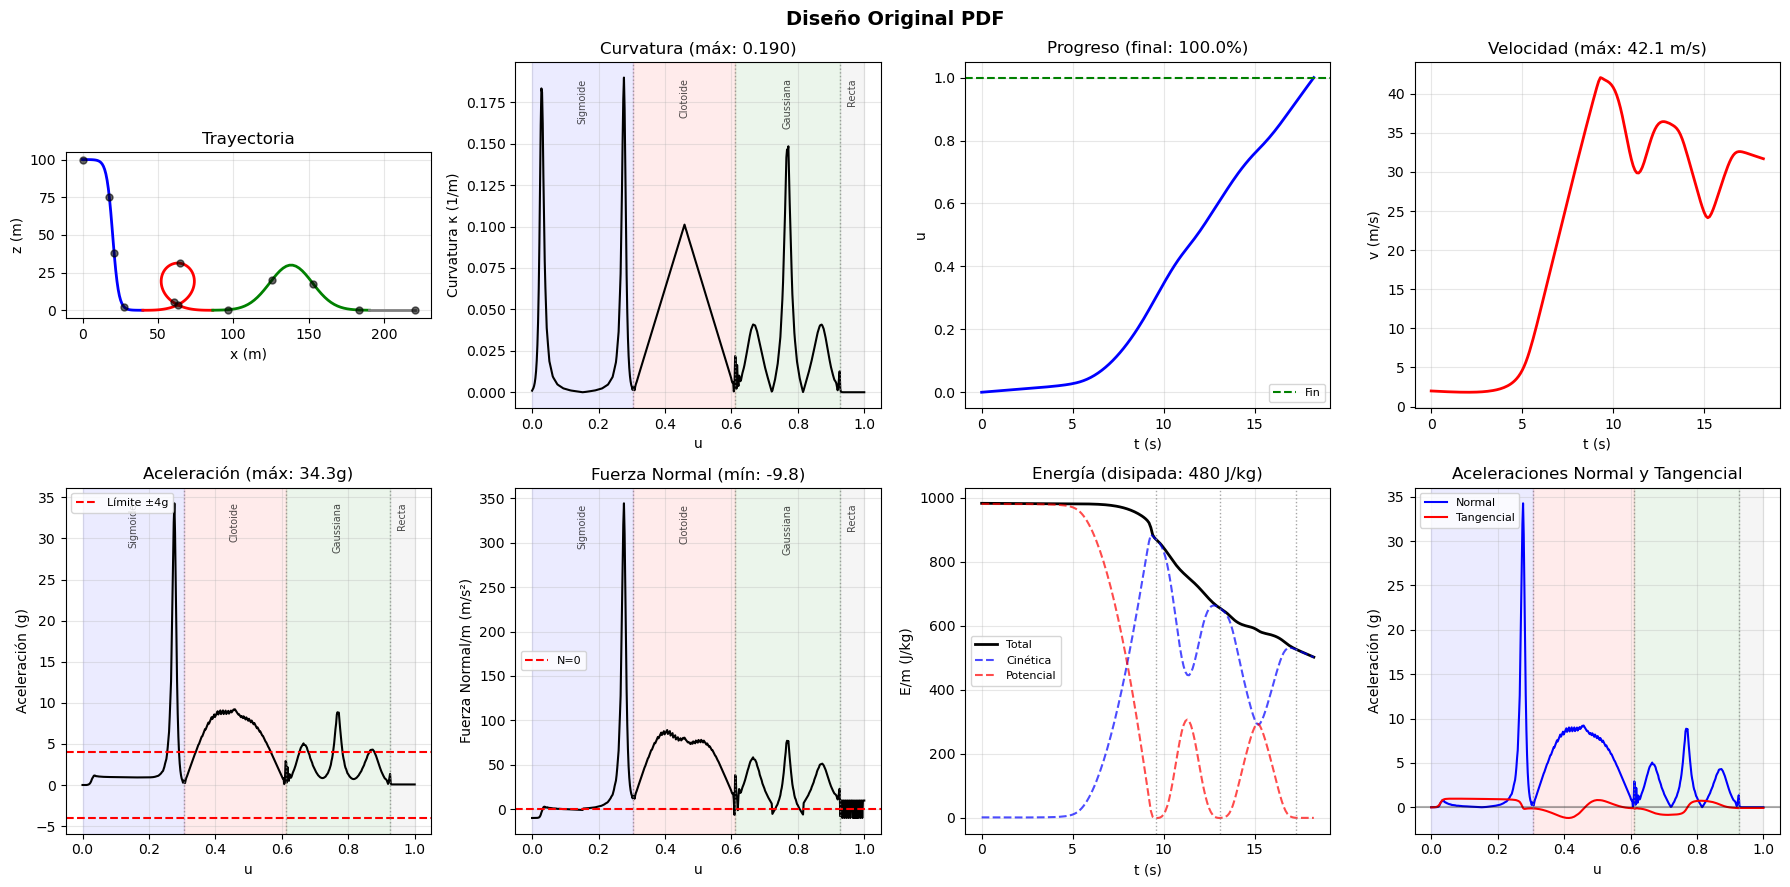

In [3]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 2D - Paso 3: Resolución de la EDO con fricción y arrastre

Parámetros físicos (del PDF página 6-7):
- Masa del vagón: m = 800 kg (4 pasajeros)
- Coeficiente de fricción: μ = 0.015
- Coeficiente de arrastre: ca = 0.4
- Superficie frontal: Sf = 2 m²
- Densidad del aire: ρa = 1.225 kg/m³
- Velocidad inicial: v0 = 2 m/s

Límites de seguridad (UNE-EN 13814-1 Anexo I):
- Aceleración positiva (Z): < +6g
- Aceleración negativa (Z): > -3g  
- Aceleración sostenida: < 4g durante más de 4s
- Fuerza normal negativa: PERMITIDA (up-stop wheels)
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# SEGMENTOS MODULARES
# =============================================================================

class Segmento:
    """Clase base para segmentos de la montaña rusa."""
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.z = None, None
    
    def generar(self, x0, z0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.z[-1]

    def derivadas(self):
        """
        Devuelve dx/du, dz/du y dz/dx (pendiente).
        """
        if self.x is None or self.z is None:
            raise ValueError("Primero hay que generar el segmento")

        dx = np.gradient(self.x)
        dz = np.gradient(self.z)

        with np.errstate(divide='ignore', invalid='ignore'):
            pendiente = dz / dx

        return dx, dz, pendiente

class Sigmoide(Segmento):
    """Descenso pronunciado (función sigmoide)."""
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_sig, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        self.x = x_sig + x0 - self.u_min
        self.z = z_sig + z0
        return self.x, self.z

class Clotoide(Segmento):
    """Loop (espiral de Euler / clotoide)."""
    def __init__(self, A=35, color='red'):
        super().__init__(f'Clotoide(A={A})', color)
        self.A = A
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, z0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_half, z_half = curvas.clotoide(u, A=self.A, p0=0)
        # Loop completo por simetría
        x_full = np.concatenate([x_half, 2*x_half[-1] - x_half[::-1][1:]])
        z_full = np.concatenate([z_half, z_half[::-1][1:]])
        self.x = x_full + x0
        self.z = z_full + z0
        return self.x, self.z

class Gaussiana(Segmento):
    """Colina (campana de Gauss)."""
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_gauss, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        self.x = x_gauss - self.u_min + x0
        self.z = z_gauss + z0
        return self.x, self.z

class Recta(Segmento):
    """Tramo recto (horizontal o inclinado)."""
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud}, m={pendiente})', color)
        self.longitud = longitud
        self.pendiente = pendiente
    
    def generar(self, x0, z0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u
        self.z = z0 + self.pendiente * u
        return self.x, self.z


# =============================================================================
# MONTAÑA RUSA 2D
# =============================================================================

class MontañaRusa2D:
    """
    Constructor modular de montaña rusa 2D.
    
    Uso:
        mr = MontañaRusa2D("Mi montaña")
        mr.agregar(Sigmoide(A=100))
        mr.agregar(Clotoide(A=35))
        mr.agregar(Gaussiana(A=30))
        mr.agregar(Recta(longitud=30))
        mr.construir()
    """
    
    def __init__(self, nombre="Montaña Rusa 2D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.z_total = None, None
        self.bspline = None
    
    def agregar(self, segmento):
        """Agrega un segmento a la montaña rusa."""
        self.segmentos.append(segmento)
        return self  # Permite encadenar: mr.agregar(A).agregar(B)
    
    def construir(self, x0=0, z0=0, n_puntos=50, verbose=True):
        """Construye la trayectoria concatenando segmentos."""
        if verbose:
            print(f"\n{'='*60}")
            print(f"CONSTRUYENDO: {self.nombre}")
            print(f"{'='*60}")
        
        x_act, z_act = x0, z0
        arrays_x, arrays_z = [], []
        
        for i, seg in enumerate(self.segmentos):
            x, z = seg.generar(x_act, z_act, n_puntos)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}")
                print(f"   x: [{x[0]:.1f}, {x[-1]:.1f}] m")
                print(f"   z: [{z.min():.1f}, {z.max():.1f}] m")
            
            arrays_x.append(x if i == 0 else x[1:])
            arrays_z.append(z if i == 0 else z[1:])
            x_act, z_act = seg.get_punto_final()
        
        self.x_total = np.concatenate(arrays_x)
        self.z_total = np.concatenate(arrays_z)
        
        # Crear B-spline
        y = np.zeros_like(self.x_total)
        puntos_3d = np.array([self.x_total, y, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        if verbose:
            print(f"{'-'*60}")
            print(f"Longitud total: {self.x_total[-1] - self.x_total[0]:.1f} m")
            print(f"Altura máxima: {self.z_total.max():.1f} m")
            print(f"Puntos: {len(self.x_total)}")
        
        return self


# =============================================================================
# PARÁMETROS FÍSICOS
# =============================================================================

class ParametrosFisicos:
    """Parámetros físicos del sistema (valores del PDF)."""
    
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, 
                 Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa = masa
        self.v0 = v0
        self.mu = mu
        self.ca = ca
        self.Sf = Sf
        self.rho_a = rho_a
        self.grav = grav
        # Coeficiente viscoso: cv = ca·Sf·ρa / (2m)
        self.cv = ca * Sf * rho_a / (2 * masa)
    
    def __str__(self):
        return (f"m={self.masa}kg, v0={self.v0}m/s, μ={self.mu}, "
                f"ca={self.ca}, cv={self.cv:.2e}")


# =============================================================================
# SIMULADOR
# =============================================================================

class Simulador:
    """
    Simulador de la montaña rusa.
    Resuelve la EDO y analiza viabilidad.
    """
    
    # Límites UNE-EN 13814-1 Anexo I
    ACEL_MAX_POSITIVA = 6.0   # g
    ACEL_MAX_NEGATIVA = -3.0  # g
    ACEL_SOSTENIDA = 4.0      # g
    TIEMPO_SOSTENIDA = 4.0    # s
    
    def __init__(self, montaña_rusa, params=None):
        self.mr = montaña_rusa
        self.params = params or ParametrosFisicos()
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.sol = None
        self.datos = None
    
    def simular(self, metodo='DOP853', tfin=200, verbose=True):
        """Resuelve la EDO."""
        if verbose:
            print(f"\nSimulando con {metodo}...")
            print(f"Parámetros: {self.params}")
        
        self.sol = scin.solve_ivp(
            mrusa.edofun_mr,
            [0, tfin],
            [0.0, self.params.v0],
            method=metodo,
            args=[self.derivadas, self.params.mu, self.params.cv, self.params.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True,
            max_step=0.1
        )
        
        self._calcular_datos()
        
        if verbose:
            self._mostrar_resultados()
        
        return self
    
    def _calcular_datos(self):
        """Calcula aceleraciones, fuerzas y curvatura a lo largo del recorrido."""
        u = self.sol.y[0]
        v = self.sol.y[1]
        t = self.sol.t
        
        u_max = min(u[-1], 1.0)
        u_eval = np.linspace(0, u_max, 500)
        
        acel_total, acel_tang, acel_normal = [], [], []
        fuerza_normal, tiempos, velocidades = [], [], []
        curvaturas = []
        
        for u_i in u_eval:
            idx = np.argmin(np.abs(u - u_i))
            v_i, t_i = v[idx], t[idx]
            
            try:
                fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, self.params.grav)
                acel = mrusa.aceleracion(v_i, base, self.params.mu, self.params.cv, 
                                         fN, ctes[1], self.params.grav)
                acel_total.append(acel[0])
                acel_tang.append(acel[1])
                acel_normal.append(acel[2])
                fuerza_normal.append(fN)
                curvaturas.append(ctes[1])  # ctes = [norma_r', curvatura, torsión]
            except:
                acel_total.append(0)
                acel_tang.append(0)
                acel_normal.append(0)
                fuerza_normal.append(0)
                curvaturas.append(0)
            
            tiempos.append(t_i)
            velocidades.append(v_i)
        
        self.datos = {
            'u': u_eval,
            't': np.array(tiempos),
            'v': np.array(velocidades),
            'acel_total': np.array(acel_total),
            'acel_tang': np.array(acel_tang),
            'acel_normal': np.array(acel_normal),
            'fuerza_normal': np.array(fuerza_normal),
            'curvatura': np.array(curvaturas)
        }
    
    def _mostrar_resultados(self):
        """Muestra resumen de resultados."""
        u_final = self.sol.y[0][-1]
        v = self.sol.y[1]
        g = self.params.grav
        
        print(f"\n{'='*60}")
        print("RESULTADOS DE LA SIMULACIÓN")
        print(f"{'='*60}")
        print(f"Recorrido completado: {u_final*100:.1f}%")
        print(f"Tiempo total: {self.sol.t[-1]:.2f} s")
        print(f"Velocidad: [{v.min():.1f}, {v.max():.1f}] m/s")
        print(f"Aceleración máxima: {self.datos['acel_total'].max()/g:.1f}g")
        print(f"Fuerza normal: [{self.datos['fuerza_normal'].min():.1f}, "
              f"{self.datos['fuerza_normal'].max():.1f}] m/s²")
        
        # Análisis de viabilidad
        print(f"\n{'-'*60}")
        print("ANÁLISIS DE VIABILIDAD")
        print(f"{'-'*60}")
        
        viable = True
        
        # 1. ¿Completa el recorrido?
        if u_final < 0.99:
            viable = False
            pos = self.bspline(u_final)
            print(f"✗ NO COMPLETA: Se detiene en u={u_final:.3f} (x={pos[0]:.1f}m, z={pos[2]:.1f}m)")
        else:
            print(f"✓ Completa el recorrido")
        
        # 2. Aceleraciones
        acel_g = self.datos['acel_total'] / g
        acel_n_g = self.datos['acel_normal'] / g
        
        if acel_n_g.max() > self.ACEL_MAX_POSITIVA:
            viable = False
            print(f"✗ Aceleración positiva excesiva: {acel_n_g.max():.1f}g (límite: {self.ACEL_MAX_POSITIVA}g)")
        
        if acel_n_g.min() < self.ACEL_MAX_NEGATIVA:
            viable = False
            print(f"✗ Aceleración negativa excesiva: {acel_n_g.min():.1f}g (límite: {self.ACEL_MAX_NEGATIVA}g)")
        
        # 3. Fuerza normal negativa (solo informativo)
        if self.datos['fuerza_normal'].min() < 0:
            print(f"ℹ Fuerza normal negativa: up-stop wheels activas")
        
        print(f"\n→ VIABLE: {'SÍ' if viable else 'NO'}")
        
        return viable
    
    def _get_limites_segmentos(self):
        """Calcula los límites de u para cada segmento."""
        limites = [0.0]
        
        # Evaluar el bspline en muchos puntos para encontrar correspondencia
        u_test = np.linspace(0, 1, 2000)
        x_test = self.bspline(u_test)[:, 0]
        
        # Para cada segmento, encontrar el u correspondiente a su x final
        for seg in self.mr.segmentos:
            x_fin_seg = seg.x[-1]
            # Encontrar el u más cercano a este x
            idx = np.argmin(np.abs(x_test - x_fin_seg))
            limites.append(u_test[idx])
        
        # Asegurar que el último es 1.0
        limites[-1] = 1.0
        
        return limites
    
    def _dibujar_separadores(self, ax, limites, vertical=True, labels=True):
        """Dibuja líneas separadoras entre segmentos."""
        colores_seg = ['blue', 'red', 'green', 'gray', 'purple', 'orange']
        nombres = [seg.nombre.split('(')[0] for seg in self.mr.segmentos]
        
        for i, u_lim in enumerate(limites[1:-1], 1):
            ax.axvline(u_lim, color='gray', ls=':', alpha=0.7, lw=1)
        
        # Colorear fondo por segmentos
        for i in range(len(limites) - 1):
            color = colores_seg[i % len(colores_seg)]
            ax.axvspan(limites[i], limites[i+1], alpha=0.08, color=color)
            if labels and i < len(nombres):
                u_mid = (limites[i] + limites[i+1]) / 2
                ymin, ymax = ax.get_ylim()
                ax.text(u_mid, ymax * 0.95, nombres[i], ha='center', va='top',
                       fontsize=7, alpha=0.7, rotation=90)
    
    def visualizar(self, guardar=True, archivo="mr2d_paso3.png"):
        """Genera visualización completa."""
        fig, axes = plt.subplots(2, 4, figsize=(18, 9))
        
        t = self.sol.t
        u = self.sol.y[0]
        v = self.sol.y[1]
        g = self.params.grav
        
        # Obtener límites de segmentos
        limites_u = self._get_limites_segmentos()
        
        # 1. Trayectoria (colorear por segmentos)
        ax = axes[0, 0]
        colores_seg = ['blue', 'red', 'green', 'gray', 'purple', 'orange']
        for i, seg in enumerate(self.mr.segmentos):
            ax.plot(seg.x, seg.z, '-', color=colores_seg[i % len(colores_seg)], 
                   lw=2, label=seg.nombre.split('(')[0])
        # Posiciones del vagón
        for u_v in np.linspace(0, u[-1], 12):
            p = self.bspline(u_v)
            ax.plot(p[0], p[2], 'ko', ms=5, alpha=0.6)
        ax.set_xlabel('x (m)')
        ax.set_ylabel('z (m)')
        ax.set_title('Trayectoria')
        #ax.legend(fontsize=7, loc='upper right')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        # 2. Curvatura (con separadores de segmentos)
        ax = axes[0, 1]
        curv = self.datos['curvatura']
        ax.plot(self.datos['u'], curv, 'k-', lw=1.5)
        ax.set_xlabel('u')
        ax.set_ylabel('Curvatura κ (1/m)')
        ax.set_title(f'Curvatura (máx: {curv.max():.3f})')
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 3. u(t)
        ax = axes[0, 2]
        ax.plot(t, u, 'b-', lw=2)
        ax.axhline(1, color='g', ls='--', label='Fin')
        ax.set_xlabel('t (s)')
        ax.set_ylabel('u')
        ax.set_title(f'Progreso (final: {u[-1]*100:.1f}%)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # 4. v(t)
        ax = axes[0, 3]
        ax.plot(t, v, 'r-', lw=2)
        ax.set_xlabel('t (s)')
        ax.set_ylabel('v (m/s)')
        ax.set_title(f'Velocidad (máx: {v.max():.1f} m/s)')
        ax.grid(True, alpha=0.3)
        
        # 5. Aceleración (con separadores de segmentos)
        ax = axes[1, 0]
        acel_g = self.datos['acel_total'] / g
        ax.plot(self.datos['u'], acel_g, 'k-', lw=1.5)
        ax.axhline(4, color='r', ls='--', label='Límite ±4g')
        ax.axhline(-4, color='r', ls='--')
        ax.set_xlabel('u')
        ax.set_ylabel('Aceleración (g)')
        ax.set_title(f'Aceleración (máx: {acel_g.max():.1f}g)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 6. Fuerza normal (con separadores de segmentos)
        ax = axes[1, 1]
        fN = self.datos['fuerza_normal']
        ax.plot(self.datos['u'], fN, 'k-', lw=1.5)
        ax.axhline(0, color='r', ls='--', label='N=0')
        ax.set_xlabel('u')
        ax.set_ylabel('Fuerza Normal/m (m/s²)')
        ax.set_title(f'Fuerza Normal (mín: {fN.min():.1f})')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 7. Energía (con separadores por tiempo)
        ax = axes[1, 2]
        z = self.bspline(u)[:, 2]
        E_cin = 0.5 * v**2
        E_pot = g * z
        E_total = E_cin + E_pot
        ax.plot(t, E_total, 'k-', lw=2, label='Total')
        ax.plot(t, E_cin, 'b--', alpha=0.7, label='Cinética')
        ax.plot(t, E_pot, 'r--', alpha=0.7, label='Potencial')
        ax.set_xlabel('t (s)')
        ax.set_ylabel('E/m (J/kg)')
        ax.set_title(f'Energía (disipada: {E_total[0]-E_total[-1]:.0f} J/kg)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        # Separadores por tiempo para energía
        for i, u_lim in enumerate(limites_u[1:-1], 1):
            idx = np.argmin(np.abs(self.sol.y[0] - u_lim))
            if idx < len(t):
                ax.axvline(t[idx], color='gray', ls=':', alpha=0.7, lw=1)
        
        # 8. Aceleración normal vs tangencial
        ax = axes[1, 3]
        acel_n_g = self.datos['acel_normal'] / g
        acel_t_g = self.datos['acel_tang'] / g
        ax.plot(self.datos['u'], acel_n_g, 'b-', lw=1.5, label='Normal')
        ax.plot(self.datos['u'], acel_t_g, 'r-', lw=1.5, label='Tangencial')
        ax.axhline(0, color='k', ls='-', alpha=0.3)
        ax.set_xlabel('u')
        ax.set_ylabel('Aceleración (g)')
        ax.set_title('Aceleraciones Normal y Tangencial')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=False)
        
        plt.suptitle(f'{self.mr.nombre}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    
    # =========================================================================
    # DEFINICIÓN DE LA MONTAÑA RUSA
    # =========================================================================
    # Modificar aquí para probar diferentes configuraciones
    
    mr = MontañaRusa2D("Diseño Original PDF")
    
    # Elementos obligatorios según el PDF:
    mr.agregar(Sigmoide(A=100, m=0.5))      # Descenso pronunciado
    mr.agregar(Clotoide(A=35))              # Loop
    mr.agregar(Gaussiana(A=30, s=20))       # Colina
    mr.agregar(Recta(longitud=30))          # Tramo final
    
    mr.construir()
    
    # =========================================================================
    # SIMULACIÓN
    # =========================================================================
    
    params = ParametrosFisicos()  # Valores del PDF
    
    sim = Simulador(mr, params)
    sim.simular(metodo='DOP853')
    sim.visualizar()


CONSTRUYENDO: Diseño Modificado
1. Sigmoide(A=100, m=0.07)
   x: [0.0, 180.0] m
   z: [0.2, 99.8] m
2. Clotoide(A=60)
   x: [180.0, 259.5] m
   z: [0.2, 53.9] m
3. Gaussiana(A=50, s=25)
   x: [259.5, 459.5] m
   z: [0.2, 49.9] m
------------------------------------------------------------
Longitud total: 459.5 m
Altura máxima: 99.8 m
Puntos: 197

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 39.64 s
Velocidad: [2.0, 40.9] m/s
Aceleración máxima: 3.9g
Fuerza normal: [-9.8, 45.4] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
ℹ Fuerza normal negativa: up-stop wheels activas

→ VIABLE: SÍ

Figura guardada: mr2d_paso3.png


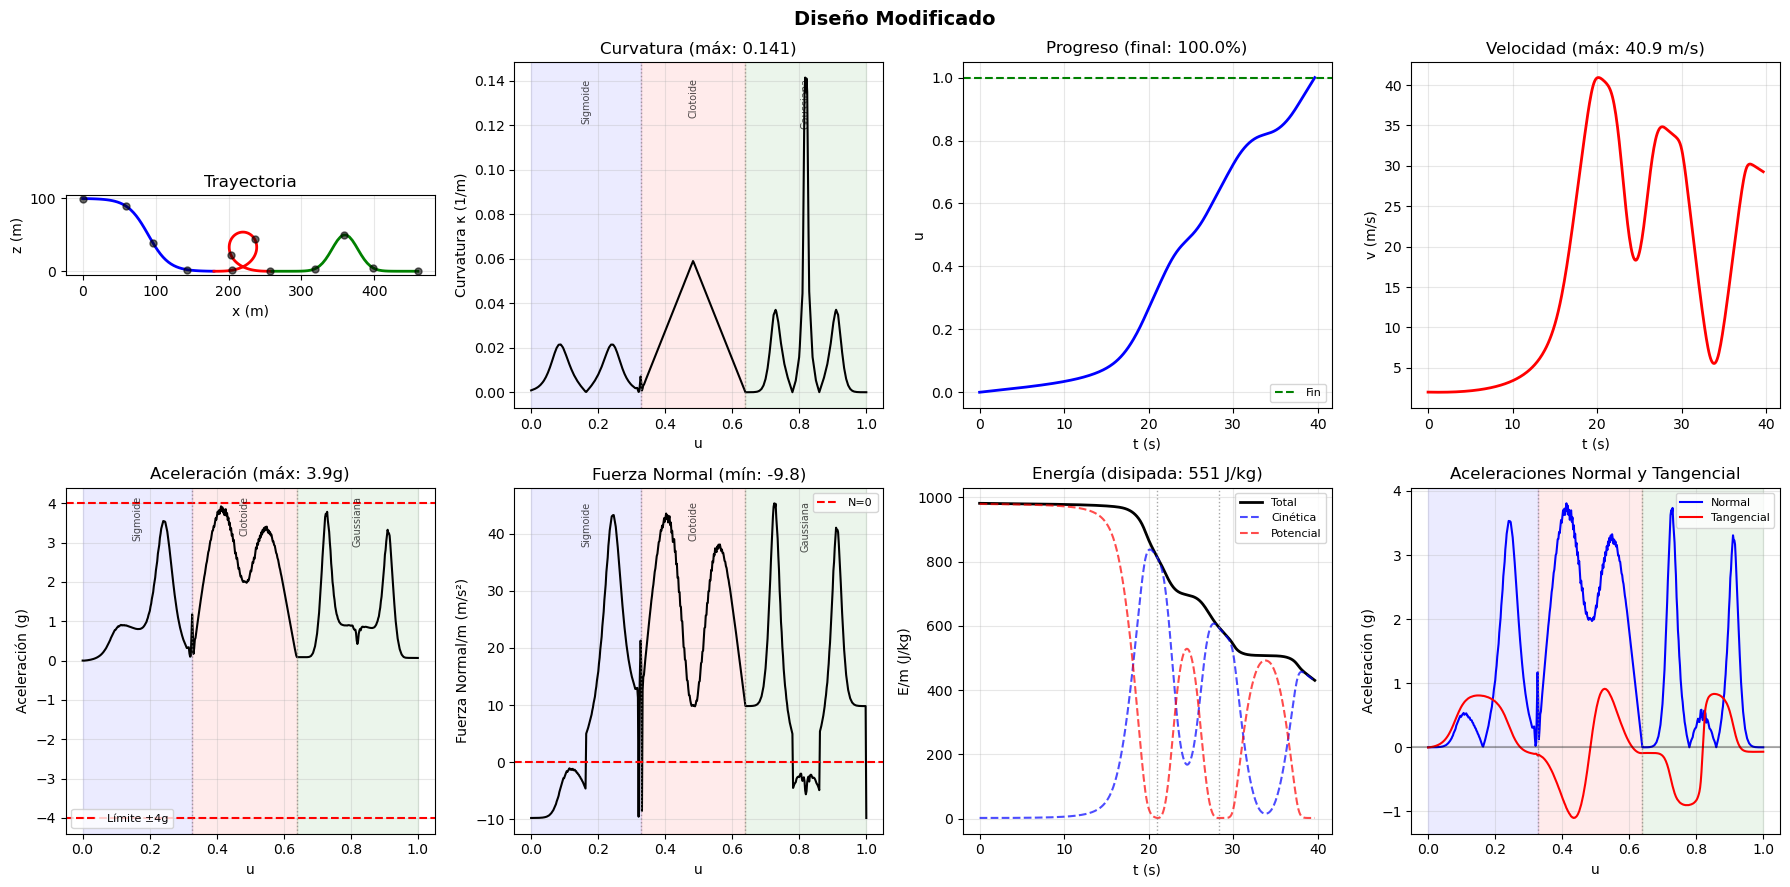

In [4]:
mr = MontañaRusa2D("Diseño Modificado")
   

mr.agregar(Sigmoide(A=100, m=0.07, u_min=-90, u_max=90))
mr.agregar(Clotoide(A=60))
#mr.agregar(Sigmoide(A=10, m=-0.07, u_min=-90, u_max=90))
mr.agregar(Gaussiana(A=50, s=25, u_min=-100, u_max=100))

mr.construir()

    
params = ParametrosFisicos()  # Valores del PDF
    
sim = Simulador(mr, params)
sim.simular(metodo='DOP853')
sim.visualizar()
plt.show()


CONSTRUYENDO: Diseño Modificado
1. Sigmoide(A=100, m=0.05)
   x: [0.0, 230.0] m
   z: [0.2, 99.3] m
2. Clotoide(A=70)
   x: [230.0, 322.8] m
   z: [0.2, 62.8] m
3. Gaussiana(A=30, s=30)
   x: [322.8, 482.8] m
   z: [0.2, 30.1] m
4. Recta(L=30, m=0)
   x: [482.8, 512.8] m
   z: [0.2, 0.2] m
------------------------------------------------------------
Longitud total: 512.8 m
Altura máxima: 99.3 m
Puntos: 246

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 36.44 s
Velocidad: [2.0, 40.4] m/s
Aceleración máxima: 3.0g
Fuerza normal: [-9.8, 35.3] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
ℹ Fuerza normal negativa: up-stop wheels activas

→ VIABLE: SÍ

Figura guardada: mr2d_paso3.png


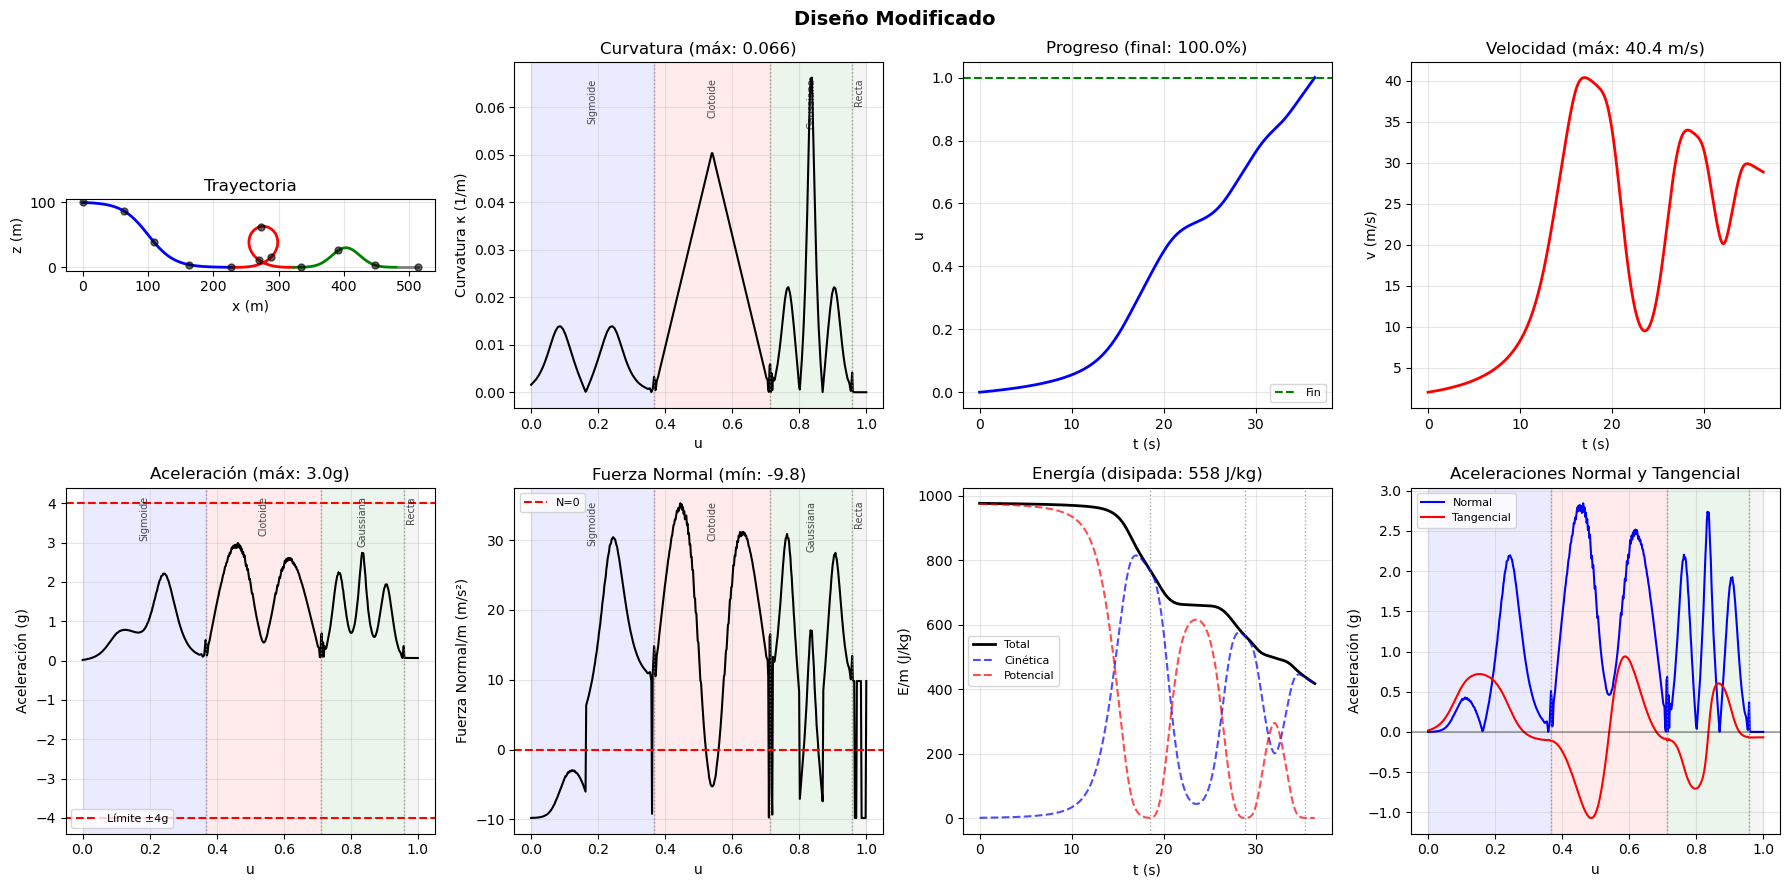

In [5]:
mr = MontañaRusa2D("Diseño Modificado")

mr.agregar(Sigmoide(A=100, m=0.05, u_min=-100, u_max=130))
mr.agregar(Clotoide(A=70))              # Loop
mr.agregar(Gaussiana(A=30, s=30, u_min=-80, u_max=80))       # Colina
mr.agregar(Recta(longitud=30))          # Tramo final

#mr.agregar(Sigmoide(A=100, m=0.07, u_min=-90, u_max=90))
#mr.agregar(Clotoide(A=60))
##mr.agregar(Sigmoide(A=10, m=-0.07, u_min=-90, u_max=90))
#mr.agregar(Gaussiana(A=50, s=25, u_min=-100, u_max=100))

mr.construir()

    
params = ParametrosFisicos()  # Valores del PDF
    
sim = Simulador(mr, params)
sim.simular(metodo='DOP853')
sim.visualizar()
plt.show()

MONTAÑA RUSA 2D - PASO 4
Estudio de intervalos válidos de parámetros

1. CONSTRUYENDO MONTAÑA RUSA BASE...

2. ANÁLISIS PARAMÉTRICO...

──────────────────────────────────────────────────────────────────────

VARIANDO: masa
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: masa ∈ [400.00, 1200.00]
----------------------------------------------------------------------
Valor nominal: 800.00 → usando 786.21
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

📈 FASE 1: Explorando hacia valores CRECIENTES...
  ✓ masa=786.21: u=100.0%, acel= 3.9g
  ✓ masa=868.97: u=100.0%, acel= 3.9g
  ✓ masa=951.72: u=100.0%, acel= 4.0g
  ✗ masa=1034.48: u=100.0%, acel= 4.2g (>4g)
  ✗ masa=1117.24: u=100.0%, acel= 4.2g (>4g)
  ✗ masa=1200.00: u=100.0%, acel= 4.3g (>4g)

📉 FASE 2: Explorando hacia valores DECRECIENTES...
  ✗ masa=731.03: u=81.7%, acel= 3.8g (NO completa)
  ✗ masa=675.86: u=81.2%, acel= 3.7g (

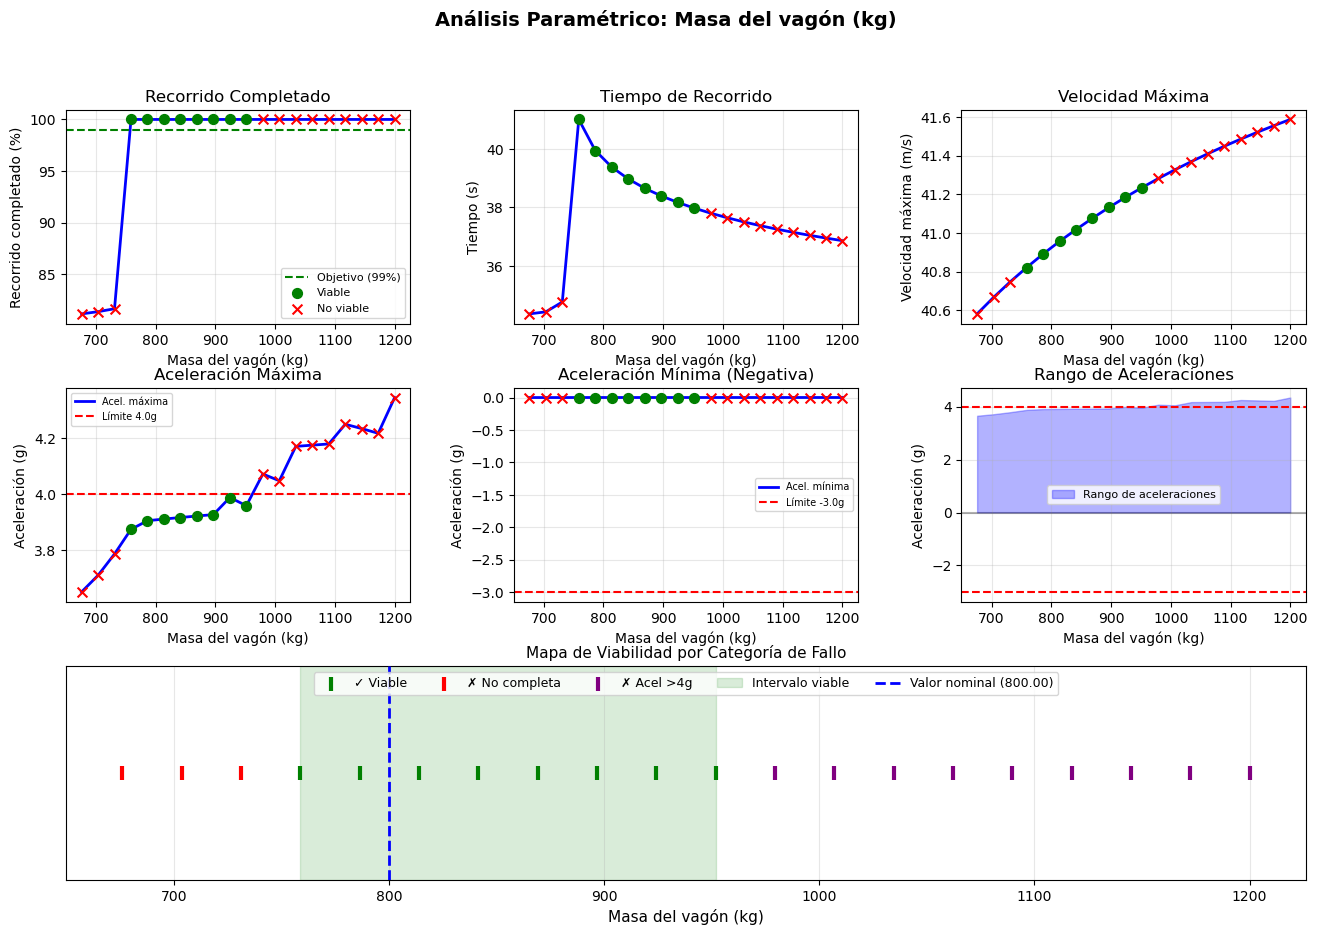


──────────────────────────────────────────────────────────────────────

VARIANDO: mu
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: mu ∈ [0.00, 0.05]
----------------------------------------------------------------------
Valor nominal: 0.01 → usando 0.01
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

📈 FASE 1: Explorando hacia valores CRECIENTES...
  ✓ mu=  0.01: u=100.0%, acel= 3.9g
  ✗ mu=  0.02: u=81.6%, acel= 3.8g (NO completa)
  ✗ mu=  0.02: u=81.0%, acel= 3.7g (NO completa)
  ⚠ Límite superior alcanzado en mu=0.02

📉 FASE 2: Explorando hacia valores DECRECIENTES...
  ✓ mu=  0.01: u=100.0%, acel= 4.0g
  ✓ mu=  0.01: u=100.0%, acel= 4.0g
  ✗ mu=  0.01: u=100.0%, acel= 4.1g (>4g)
  ✗ mu=  0.01: u=100.0%, acel= 4.2g (>4g)
  ✗ mu=  0.01: u=100.0%, acel= 4.3g (>4g)
  ✗ mu=  0.00: u=100.0%, acel= 4.3g (>4g)
  ✗ mu=  0.00: u=100.0%, acel= 4.5g (>4g)
  ✗ mu=  0.00: u=100.0%, acel

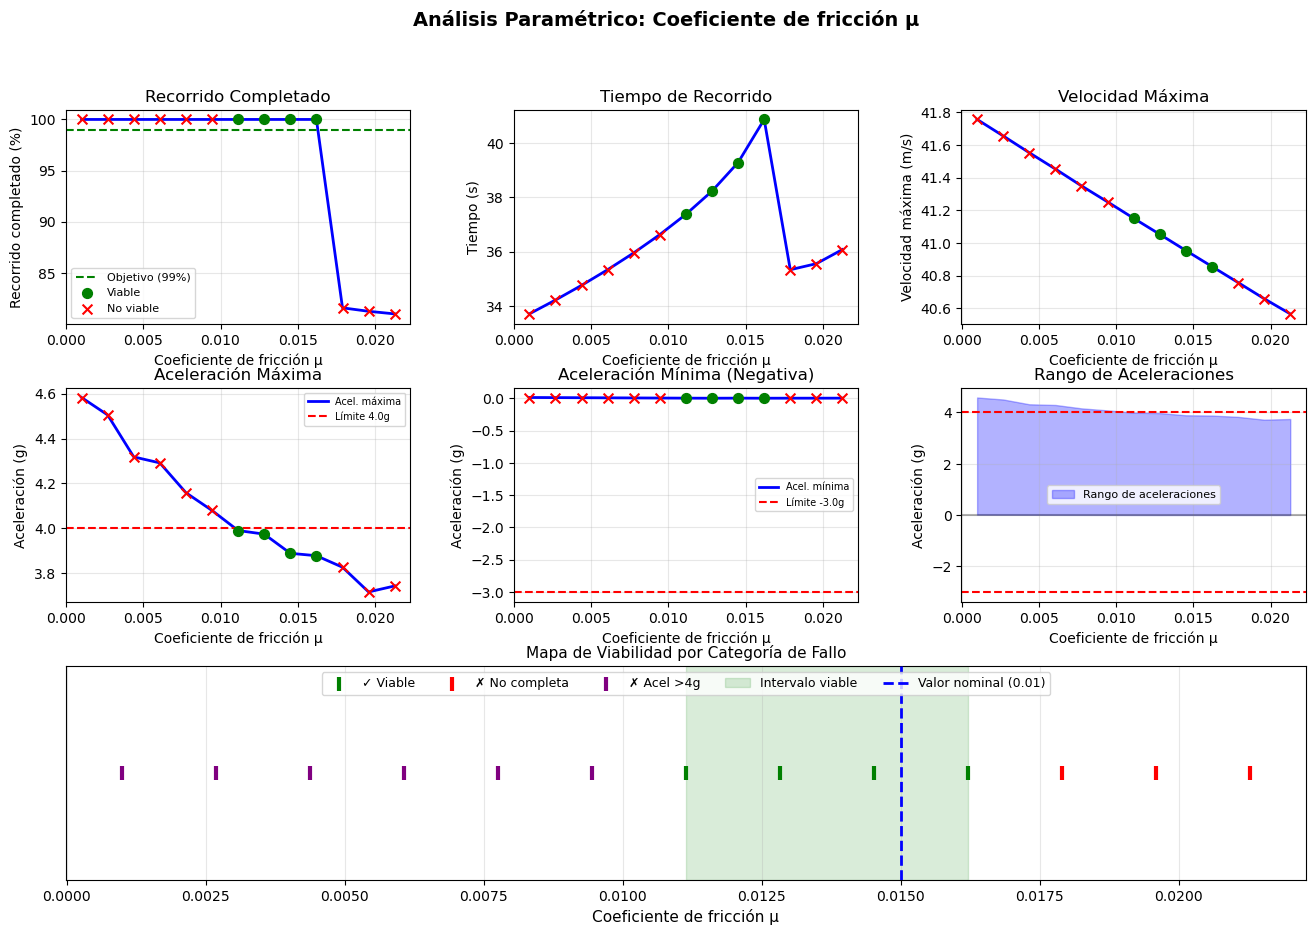


──────────────────────────────────────────────────────────────────────

VARIANDO: ca
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: ca ∈ [0.05, 1.50]
----------------------------------------------------------------------
Valor nominal: 0.40 → usando 0.40
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

📈 FASE 1: Explorando hacia valores CRECIENTES...
  ✓ ca=  0.40: u=100.0%, acel= 3.9g
  ✗ ca=  0.45: u=81.4%, acel= 3.7g (NO completa)
  ⚠ Límite superior alcanzado en ca=0.55

📉 FASE 2: Explorando hacia valores DECRECIENTES...
  ✓ ca=  0.35: u=100.0%, acel= 4.0g
  ✗ ca=  0.30: u=100.0%, acel= 4.2g (>4g)
  ✗ ca=  0.25: u=100.0%, acel= 4.3g (>4g)
  ✗ ca=  0.20: u=100.0%, acel= 4.6g (>4g)
  ✗ ca=  0.15: u=100.0%, acel= 4.9g (>4g)
  ✗ ca=  0.10: u=100.0%, acel= 5.5g (>4g)
  ✗ ca=  0.05: u=100.0%, acel= 6.6g (>4g)

──────────────────────────────────────────────────────────────────────


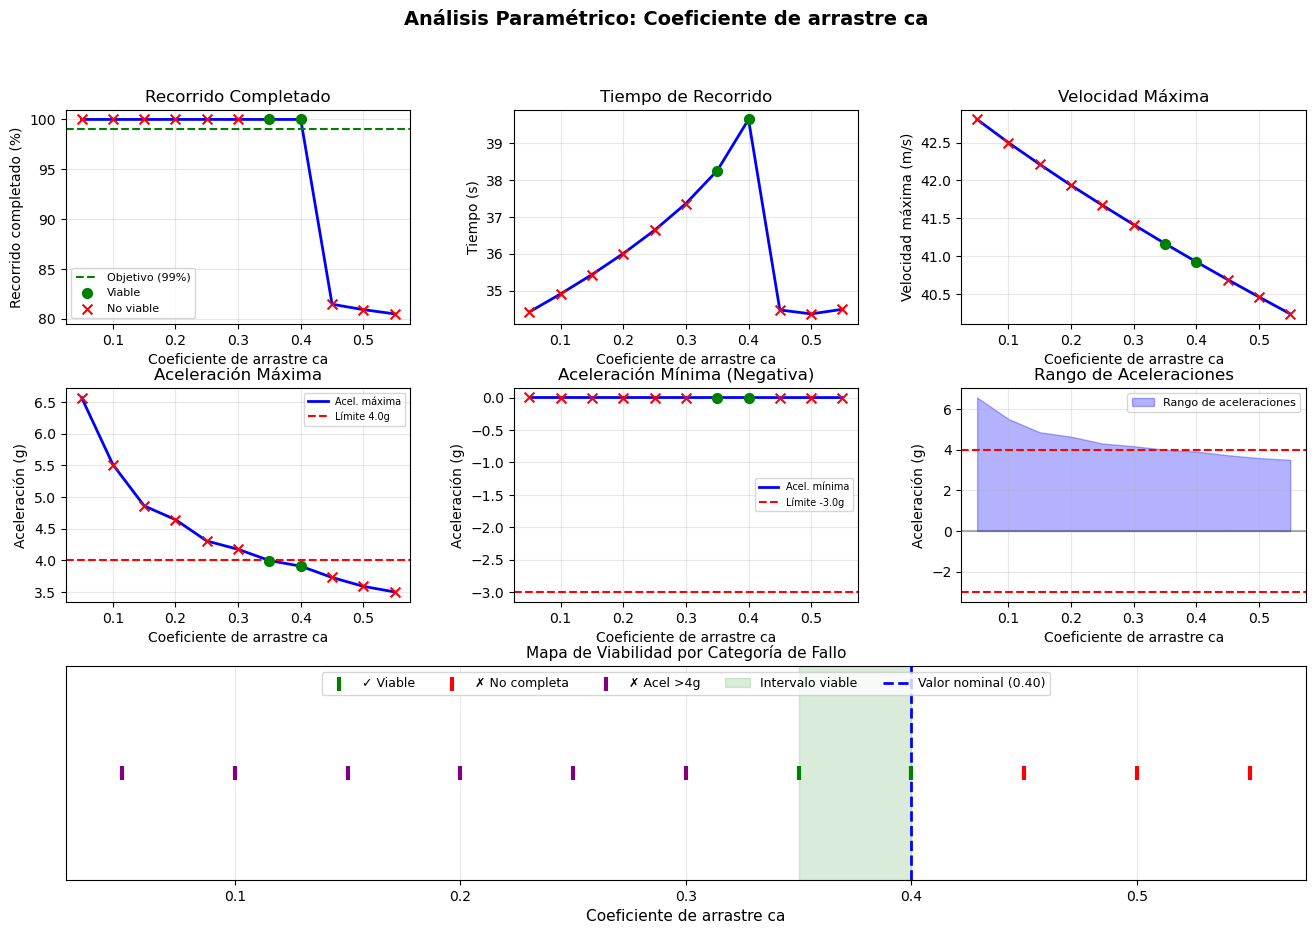


──────────────────────────────────────────────────────────────────────

VARIANDO: Sf
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: Sf ∈ [0.50, 5.00]
----------------------------------------------------------------------
Valor nominal: 2.00 → usando 2.05
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

📈 FASE 1: Explorando hacia valores CRECIENTES...
  ✓ Sf=  2.05: u=100.0%, acel= 3.9g
  ✗ Sf=  2.21: u=81.6%, acel= 3.8g (NO completa)
  ⚠ Límite superior alcanzado en Sf=2.52

📉 FASE 2: Explorando hacia valores DECRECIENTES...
  ✓ Sf=  1.74: u=100.0%, acel= 4.0g
  ✗ Sf=  1.43: u=100.0%, acel= 4.2g (>4g)
  ✗ Sf=  1.12: u=100.0%, acel= 4.5g (>4g)
  ✗ Sf=  0.81: u=100.0%, acel= 4.7g (>4g)
  ✗ Sf=  0.50: u=100.0%, acel= 5.5g (>4g)

──────────────────────────────────────────────────────────────────────
→ INTERVALO VIABLE: Sf ∈ [1.74, 2.05]
  Valor nominal: 2.00
  Margen inferior: 0.26 

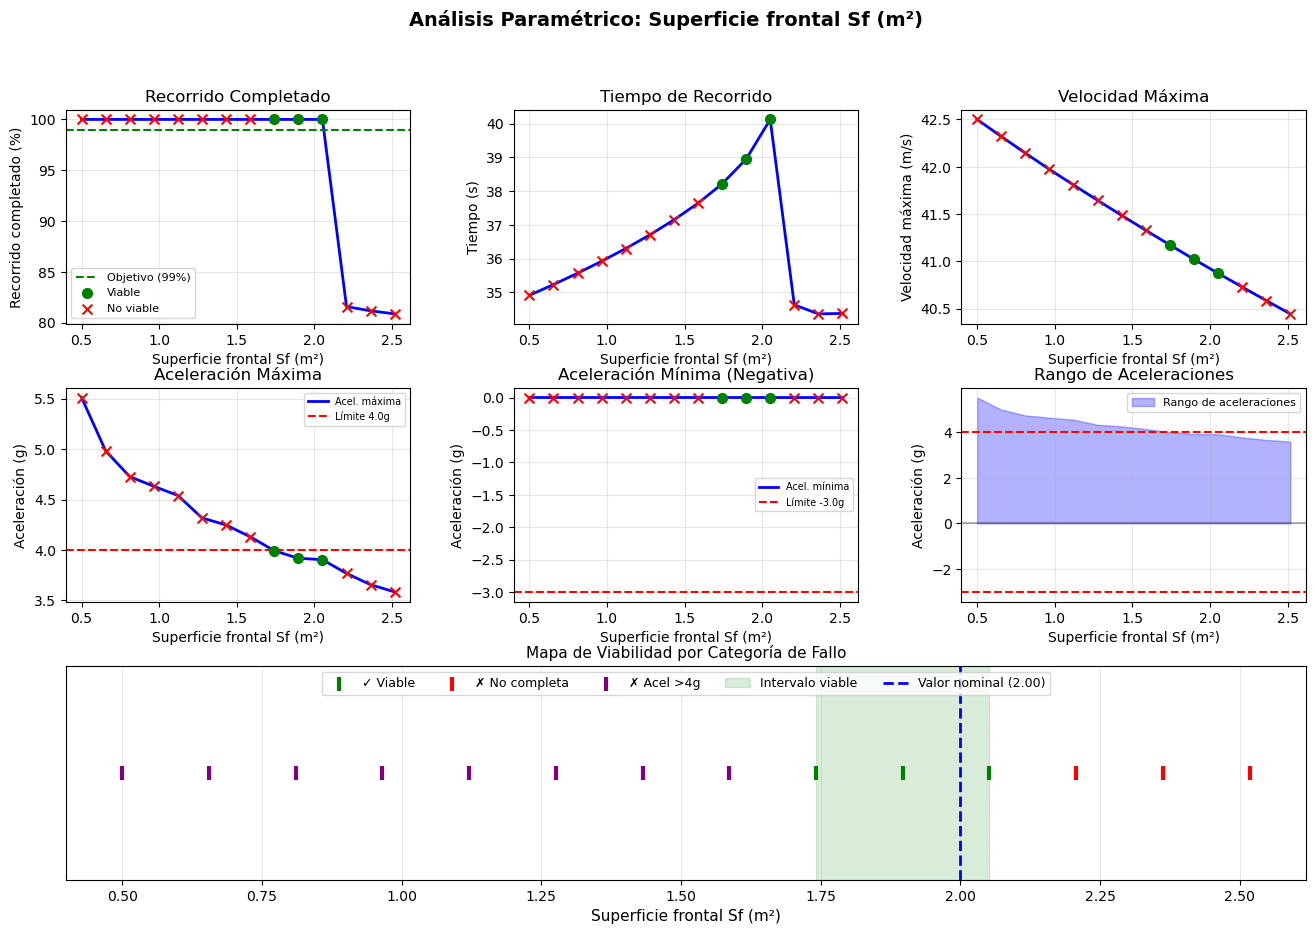


──────────────────────────────────────────────────────────────────────
NOTA: Velocidad inicial - verificando si se estanca al inicio
      (Con descenso A=100m, la energía potencial domina sobre v0)

VARIANDO: v0
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: v0 ∈ [0.01, 8.00]
----------------------------------------------------------------------
Valor nominal: 2.00 → usando 2.06
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

📈 FASE 1: Explorando hacia valores CRECIENTES...
  ✓ v0=  2.06: u=100.0%, acel= 3.8g
  ✓ v0=  3.29: u=100.0%, acel= 3.8g
  ✓ v0=  4.52: u=100.0%, acel= 3.8g
  ✓ v0=  5.75: u=100.0%, acel= 3.9g
  ✓ v0=  6.98: u=100.0%, acel= 3.8g

📉 FASE 2: Explorando hacia valores DECRECIENTES...
  ✓ v0=  1.65: u=100.0%, acel= 3.8g
  ✓ v0=  1.24: u=100.0%, acel= 3.9g
  ✓ v0=  0.83: u=100.0%, acel= 3.9g
  ✗ v0=  0.62: u= 0.9%, acel= 0.0g (ESTANCADO - no se mueve)
  ⚠ Estan

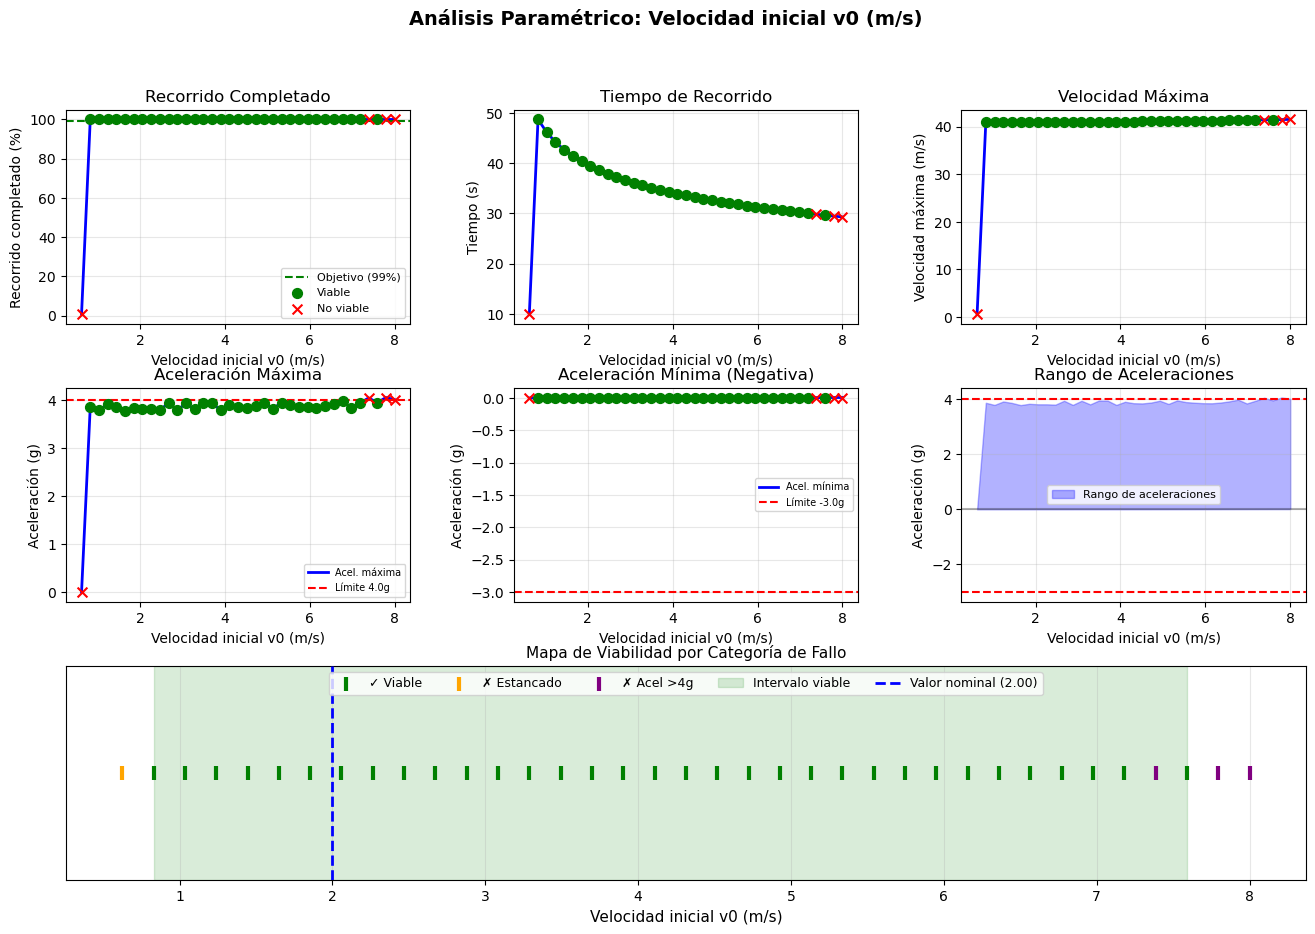


RESUMEN DE INTERVALOS VÁLIDOS
Parámetro            Valor Base      Intervalo Viable              
----------------------------------------------------------------------
Masa (kg)            800.00          [758.62, 951.72]              
Coef. fricción μ     0.01            [0.01, 0.02]                  
Coef. arrastre ca    0.40            [0.35, 0.40]                  
Superficie Sf (m²)   2.00            [1.74, 2.05]                  
Velocidad v0 (m/s)   2.00            [0.83, 7.59]                  

PASO 4 COMPLETADO

Interpretación de resultados:

1. MASA (m): A mayor masa, mayor inercia → necesita más energía inicial
   pero también es menos afectada por fricción y arrastre.

2. FRICCIÓN (μ): Pérdidas proporcionales a μ·N. Valores altos impiden
   completar el recorrido.

3. ARRASTRE (ca): Pérdidas proporcionales a ca·v². Efecto mayor a 
   altas velocidades (descenso inicial).

4. SUPERFICIE FRONTAL (Sf): Similar a ca, aumenta resistencia aerodinámica.

5. VELOCIDAD INICIAL (v

In [6]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 2D - Paso 4: Estudio de intervalos válidos de parámetros

Análisis de sensibilidad para:
- Masa del vagón (m)
- Coeficiente de fricción (μ)
- Coeficiente de arrastre (ca)
- Superficie frontal (Sf)
- Velocidad inicial (v0)

Criterios de viabilidad:
- Completa el recorrido (u_final ≥ 0.99)
- Aceleración máxima < 6g (según UNE-EN 13814-1)
- Aceleración sostenida < 4g durante más de 4s
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from matplotlib.gridspec import GridSpec

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# CLASES AUXILIARES (del paso 3)
# =============================================================================

class Segmento:
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.z = None, None
    
    def generar(self, x0, z0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.z[-1]

class Sigmoide(Segmento):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_sig, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        self.x = x_sig + x0 - self.u_min
        self.z = z_sig + z0
        return self.x, self.z

class Clotoide(Segmento):
    def __init__(self, A=35, color='red'):
        super().__init__(f'Clotoide(A={A})', color)
        self.A = A
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, z0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_half, z_half = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_half, 2*x_half[-1] - x_half[::-1][1:]])
        z_full = np.concatenate([z_half, z_half[::-1][1:]])
        self.x = x_full + x0
        self.z = z_full + z0
        return self.x, self.z

class Gaussiana(Segmento):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        x_gauss, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        self.x = x_gauss - self.u_min + x0
        self.z = z_gauss + z0
        return self.x, self.z

class MontañaRusa2D:
    def __init__(self, nombre="Montaña Rusa 2D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.z_total = None, None
        self.bspline = None
    
    def agregar(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, z0=0, n_puntos=50, verbose=False):
        x_act, z_act = x0, z0
        arrays_x, arrays_z = [], []
        
        for i, seg in enumerate(self.segmentos):
            x, z = seg.generar(x_act, z_act, n_puntos)
            arrays_x.append(x if i == 0 else x[1:])
            arrays_z.append(z if i == 0 else z[1:])
            x_act, z_act = seg.get_punto_final()
        
        self.x_total = np.concatenate(arrays_x)
        self.z_total = np.concatenate(arrays_z)
        
        y = np.zeros_like(self.x_total)
        puntos_3d = np.array([self.x_total, y, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        return self

class ParametrosFisicos:
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, 
                 Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa = masa
        self.v0 = v0
        self.mu = mu
        self.ca = ca
        self.Sf = Sf
        self.rho_a = rho_a
        self.grav = grav
        self.cv = ca * Sf * rho_a / (2 * masa)

# =============================================================================
# CLASE PARA ANÁLISIS PARAMÉTRICO
# =============================================================================

class AnalizadorParametrico:
    """
    Realiza análisis de sensibilidad variando un parámetro mientras
    mantiene los demás constantes.
    """
    
    # Límites de seguridad UNE-EN 13814-1 Anexo I (página 175 del PDF)
    ACEL_MAX_POSITIVA = 4.0   # g (aceleración sostenida)
    ACEL_MAX_NEGATIVA = -3.0  # g (aceleración negativa)
    ACEL_SOSTENIDA = 4.0      # g
    TIEMPO_SOSTENIDA = 4.0    # s
    
    def __init__(self, montaña_rusa, params_base):
        self.mr = montaña_rusa
        self.params_base = params_base
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def simular_con_params(self, params, verbose=False):
        """Simula y retorna métricas de viabilidad."""
        try:
            sol = scin.solve_ivp(
                mrusa.edofun_mr,
                [0, 200],
                [0.0, params.v0],
                method='DOP853',
                args=[self.derivadas, params.mu, params.cv, params.grav],
                events=[mrusa.finalVia, mrusa.paradaVagon],
                dense_output=True,
                max_step=0.1
            )
            
            if not sol.success:
                return None
            
            u_final = sol.y[0][-1]
            v = sol.y[1]
            t = sol.t
            
            # VERIFICACIÓN: ¿Se quedó estancado al inicio?
            # Si después de 10s no ha avanzado >1% del recorrido, está parado
            if len(t) > 10:
                idx_10s = np.argmin(np.abs(t - 10))
                u_10s = u_final if idx_10s >= len(sol.y[0]) else sol.y[0][idx_10s]
                if u_10s < 0.01:  # No avanzó ni 1% en 10 segundos
                    if verbose:
                        print(f"  ⚠ Vagón estancado: u(10s)={u_10s:.3%}")
                    # Marcar como no viable
                    return {
                        'completa': False,
                        'u_final': u_10s,
                        't_final': 10.0,
                        'v_max': params.v0,
                        'v_min': 0.0,
                        'acel_max_g': 0.0,
                        'acel_min_g': 0.0,
                        'acel_excede_4g': False,
                        'acel_excede_neg3g': False,
                        'acel_sostenida_violada': False,
                        'viable': False,
                        'valor_param': None,
                        'sol': sol,
                        'estancado': True
                    }
            
            # Calcular aceleraciones
            u_eval = np.linspace(0, min(u_final, 1.0), 200)
            acel_total = []
            
            for u_i in u_eval:
                idx = np.argmin(np.abs(sol.y[0] - u_i))
                v_i = v[idx]
                try:
                    fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, params.grav)
                    acel = mrusa.aceleracion(v_i, base, params.mu, params.cv, 
                                            fN, ctes[1], params.grav)
                    acel_total.append(acel[0])
                except:
                    acel_total.append(0)
            
            acel_total = np.array(acel_total)
            acel_g = acel_total / params.grav
            
            # Verificar aceleración sostenida
            violacion_sostenida = False
            if len(t) > 10:
                dt = np.diff(t)
                for i in range(len(acel_g) - 10):
                    if np.all(np.abs(acel_g[i:i+10]) > self.ACEL_SOSTENIDA):
                        tiempo_acum = np.sum(dt[i:i+10]) if i < len(dt)-10 else 0
                        if tiempo_acum > self.TIEMPO_SOSTENIDA:
                            violacion_sostenida = True
                            break
            
            metricas = {
                'completa': u_final >= 0.99,
                'u_final': u_final,
                't_final': t[-1],
                'v_max': v.max(),
                'v_min': v.min(),
                'acel_max_g': acel_g.max(),
                'acel_min_g': acel_g.min(),
                'acel_excede_4g': acel_g.max() > self.ACEL_MAX_POSITIVA,
                'acel_excede_neg3g': acel_g.min() < self.ACEL_MAX_NEGATIVA,
                'acel_sostenida_violada': violacion_sostenida,
                'viable': (u_final >= 0.99 and 
                          acel_g.max() <= self.ACEL_MAX_POSITIVA and
                          acel_g.min() >= self.ACEL_MAX_NEGATIVA and
                          not violacion_sostenida),
                'sol': sol,
                'estancado': False
            }
            
            return metricas
            
        except Exception as e:
            if verbose:
                print(f"Error en simulación: {e}")
            return None
    
    def variar_parametro(self, nombre_param, valores, verbose=True):
        """
        Varía un parámetro manteniendo los demás constantes.
        Estrategia: Partir del valor nominal y explorar en ambas direcciones.
        
        Parámetros:
        -----------
        nombre_param : str - 'masa', 'mu', 'ca', 'Sf', 'v0'
        valores : array - valores a probar
        """
        if verbose:
            print(f"\n{'='*70}")
            print(f"VARIANDO: {nombre_param}")
            print(f"{'='*70}")
            print(f"Valores base: m={self.params_base.masa}kg, "
                  f"μ={self.params_base.mu}, ca={self.params_base.ca}, "
                  f"Sf={self.params_base.Sf}m², v0={self.params_base.v0}m/s")
            print(f"Rango de análisis: {nombre_param} ∈ [{valores[0]:.2f}, {valores[-1]:.2f}]")
            print(f"{'-'*70}")
        
        # Obtener valor nominal
        if nombre_param == 'masa':
            val_nominal = self.params_base.masa
        elif nombre_param == 'mu':
            val_nominal = self.params_base.mu
        elif nombre_param == 'ca':
            val_nominal = self.params_base.ca
        elif nombre_param == 'Sf':
            val_nominal = self.params_base.Sf
        elif nombre_param == 'v0':
            val_nominal = self.params_base.v0
        else:
            raise ValueError(f"Parámetro '{nombre_param}' no reconocido")
        
        # Encontrar índice más cercano al valor nominal
        idx_nominal = np.argmin(np.abs(valores - val_nominal))
        val_nominal_real = valores[idx_nominal]
        
        if verbose:
            print(f"Valor nominal: {val_nominal:.2f} → usando {val_nominal_real:.2f}")
            print(f"Estrategia: Nominal → Máximo, luego Nominal → Mínimo")
            print(f"{'-'*70}")
        
        resultados = []
        
        # =====================================================================
        # FASE 1: Desde nominal hacia ARRIBA (valores crecientes)
        # =====================================================================
        if verbose:
            print("\n📈 FASE 1: Explorando hacia valores CRECIENTES...")
        
        no_completa_consecutivos = 0
        for i in range(idx_nominal, len(valores)):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas is not None:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                if not metricas['completa']:
                    no_completa_consecutivos += 1
                else:
                    no_completa_consecutivos = 0
                
                if verbose and (i == idx_nominal or 
                               (i - idx_nominal) % max(1, (len(valores) - idx_nominal)//5) == 0 or
                               no_completa_consecutivos == 1):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                # Parar si no completa 3 veces consecutivas (monotonicidad)
                if no_completa_consecutivos >= 3:
                    if verbose:
                        print(f"  ⚠ Límite superior alcanzado en {nombre_param}={val:.2f}")
                    break
        
        # =====================================================================
        # FASE 2: Desde nominal hacia ABAJO (valores decrecientes)
        # =====================================================================
        if verbose:
            print("\n📉 FASE 2: Explorando hacia valores DECRECIENTES...")
        
        no_completa_consecutivos = 0
        # Empezar desde idx_nominal-1 (ya hicimos idx_nominal en fase 1)
        for i in range(idx_nominal - 1, -1, -1):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas is not None:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                # OPTIMIZACIÓN ESPECIAL: Si se queda estancado, parar inmediatamente
                # (especialmente importante para v0 muy bajos)
                if metricas.get('estancado', False):
                    if verbose:
                        self._imprimir_resultado(nombre_param, val, metricas)
                        print(f"  ⚠ Estancamiento detectado - límite inferior crítico en {nombre_param}={val:.2f}")
                    break
                
                if not metricas['completa']:
                    no_completa_consecutivos += 1
                else:
                    no_completa_consecutivos = 0
                
                if verbose and ((idx_nominal - i) % max(1, idx_nominal//5) == 0 or
                               no_completa_consecutivos == 1):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                # Parar si no completa 3 veces consecutivas
                if no_completa_consecutivos >= 3:
                    if verbose:
                        print(f"  ⚠ Límite inferior alcanzado en {nombre_param}={val:.2f}")
                    break
        
        # Ordenar resultados por valor del parámetro
        resultados.sort(key=lambda x: x['valor_param'])
        
        self.resultados[nombre_param] = resultados
        
        # Determinar intervalo viable
        viables = [r for r in resultados if r['viable']]
        if viables:
            vals_viables = [r['valor_param'] for r in viables]
            intervalo = (min(vals_viables), max(vals_viables))
            if verbose:
                print(f"\n{'─'*70}")
                print(f"→ INTERVALO VIABLE: {nombre_param} ∈ [{intervalo[0]:.2f}, {intervalo[1]:.2f}]")
                print(f"  Valor nominal: {val_nominal:.2f}")
                print(f"  Margen inferior: {val_nominal - intervalo[0]:.2f} ({(val_nominal - intervalo[0])/val_nominal*100:.1f}%)")
                print(f"  Margen superior: {intervalo[1] - val_nominal:.2f} ({(intervalo[1] - val_nominal)/val_nominal*100:.1f}%)")
                print(f"  Configuraciones viables: {len(viables)}/{len(resultados)}")
        else:
            intervalo = None
            if verbose:
                print(f"\n→ ⚠ NO HAY VALORES VIABLES en el rango analizado")
        
        return resultados, intervalo
    
    def _crear_params_modificados(self, nombre_param, val):
        """Crea objeto ParametrosFisicos con un parámetro modificado."""
        params = ParametrosFisicos(
            masa=self.params_base.masa,
            v0=self.params_base.v0,
            mu=self.params_base.mu,
            ca=self.params_base.ca,
            Sf=self.params_base.Sf
        )
        
        if nombre_param == 'masa':
            params.masa = val
            params.cv = params.ca * params.Sf * params.rho_a / (2 * val)
        elif nombre_param == 'mu':
            params.mu = val
        elif nombre_param == 'ca':
            params.ca = val
            params.cv = val * params.Sf * params.rho_a / (2 * params.masa)
        elif nombre_param == 'Sf':
            params.Sf = val
            params.cv = params.ca * val * params.rho_a / (2 * params.masa)
        elif nombre_param == 'v0':
            params.v0 = val
        
        return params
    
    def _imprimir_resultado(self, nombre_param, val, metricas):
        """Imprime resultado de una simulación."""
        simbolo = '✓' if metricas['viable'] else '✗'
        razon = ""
        
        if metricas.get('estancado', False):
            razon = " (ESTANCADO - no se mueve)"
        elif not metricas['completa']:
            razon = " (NO completa)"
        elif metricas['acel_excede_4g']:
            razon = " (>4g)"
        elif metricas['acel_excede_neg3g']:
            razon = " (<-3g)"
        elif metricas['acel_sostenida_violada']:
            razon = " (sostenida>4g)"
        
        print(f"  {simbolo} {nombre_param}={val:6.2f}: "
              f"u={metricas['u_final']:5.1%}, "
              f"acel={metricas['acel_max_g']:4.1f}g{razon}")
    
    def visualizar_parametro(self, nombre_param, guardar=True):
        """Genera gráficos de análisis para un parámetro."""
        if nombre_param not in self.resultados:
            print(f"No hay resultados para {nombre_param}")
            return
        
        resultados = self.resultados[nombre_param]
        if not resultados:
            print(f"Lista de resultados vacía para {nombre_param}")
            return
        
        # Extraer datos
        vals = np.array([r['valor_param'] for r in resultados])
        u_final = np.array([r['u_final'] for r in resultados])
        t_final = np.array([r['t_final'] for r in resultados])
        v_max = np.array([r['v_max'] for r in resultados])
        acel_max_g = np.array([r['acel_max_g'] for r in resultados])
        acel_min_g = np.array([r['acel_min_g'] for r in resultados])
        viable = np.array([r['viable'] for r in resultados])
        
        # Crear figura
        fig = plt.figure(figsize=(16, 10))
        gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # Mapeo de nombres bonitos
        nombres = {
            'masa': 'Masa del vagón (kg)',
            'mu': 'Coeficiente de fricción μ',
            'ca': 'Coeficiente de arrastre ca',
            'Sf': 'Superficie frontal Sf (m²)',
            'v0': 'Velocidad inicial v0 (m/s)'
        }
        nombre_eje = nombres.get(nombre_param, nombre_param)
        
        # 1. Recorrido completado
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(vals, u_final * 100, 'b-', lw=2)
        ax1.axhline(99, color='g', ls='--', label='Objetivo (99%)')
        ax1.scatter(vals[viable], (u_final * 100)[viable], c='g', s=50, 
                   marker='o', label='Viable', zorder=5)
        ax1.scatter(vals[~viable], (u_final * 100)[~viable], c='r', s=50, 
                   marker='x', label='No viable', zorder=5)
        ax1.set_xlabel(nombre_eje)
        ax1.set_ylabel('Recorrido completado (%)')
        ax1.set_title('Recorrido Completado')
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Tiempo de recorrido
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(vals, t_final, 'b-', lw=2)
        ax2.scatter(vals[viable], t_final[viable], c='g', s=50, marker='o', zorder=5)
        ax2.scatter(vals[~viable], t_final[~viable], c='r', s=50, marker='x', zorder=5)
        ax2.set_xlabel(nombre_eje)
        ax2.set_ylabel('Tiempo (s)')
        ax2.set_title('Tiempo de Recorrido')
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad máxima
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(vals, v_max, 'b-', lw=2)
        ax3.scatter(vals[viable], v_max[viable], c='g', s=50, marker='o', zorder=5)
        ax3.scatter(vals[~viable], v_max[~viable], c='r', s=50, marker='x', zorder=5)
        ax3.set_xlabel(nombre_eje)
        ax3.set_ylabel('Velocidad máxima (m/s)')
        ax3.set_title('Velocidad Máxima')
        ax3.grid(True, alpha=0.3)
        
        # 4. Aceleración máxima
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.plot(vals, acel_max_g, 'b-', lw=2, label='Acel. máxima')
        ax4.axhline(self.ACEL_MAX_POSITIVA, color='r', ls='--', 
                   label=f'Límite {self.ACEL_MAX_POSITIVA}g')
        ax4.scatter(vals[viable], acel_max_g[viable], c='g', s=50, marker='o', zorder=5)
        ax4.scatter(vals[~viable], acel_max_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax4.set_xlabel(nombre_eje)
        ax4.set_ylabel('Aceleración (g)')
        ax4.set_title('Aceleración Máxima')
        ax4.legend(fontsize=7)
        ax4.grid(True, alpha=0.3)
        
        # 5. Aceleración mínima
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(vals, acel_min_g, 'b-', lw=2, label='Acel. mínima')
        ax5.axhline(self.ACEL_MAX_NEGATIVA, color='r', ls='--', 
                   label=f'Límite {self.ACEL_MAX_NEGATIVA}g')
        ax5.scatter(vals[viable], acel_min_g[viable], c='g', s=50, marker='o', zorder=5)
        ax5.scatter(vals[~viable], acel_min_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax5.set_xlabel(nombre_eje)
        ax5.set_ylabel('Aceleración (g)')
        ax5.set_title('Aceleración Mínima (Negativa)')
        ax5.legend(fontsize=7)
        ax5.grid(True, alpha=0.3)
        
        # 6. Rango de aceleraciones
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.fill_between(vals, acel_min_g, acel_max_g, alpha=0.3, color='blue', 
                         label='Rango de aceleraciones')
        ax6.axhline(self.ACEL_MAX_POSITIVA, color='r', ls='--')
        ax6.axhline(self.ACEL_MAX_NEGATIVA, color='r', ls='--')
        ax6.axhline(0, color='k', ls='-', alpha=0.3)
        ax6.set_xlabel(nombre_eje)
        ax6.set_ylabel('Aceleración (g)')
        ax6.set_title('Rango de Aceleraciones')
        ax6.legend(fontsize=8)
        ax6.grid(True, alpha=0.3)
        
        # 7. Mapa de viabilidad
        ax7 = fig.add_subplot(gs[2, :])
        
        # Separar por tipo de fallo
        viable_mask = viable
        estancado_mask = np.array([r.get('estancado', False) for r in resultados])
        no_completa_mask = np.array([not r['completa'] and not r.get('estancado', False) 
                                      for r in resultados])
        acel_alta_mask = np.array([r['completa'] and r['acel_excede_4g'] 
                                    for r in resultados])
        
        # Plotear por categorías
        if any(viable_mask):
            ax7.scatter(vals[viable_mask], np.ones(sum(viable_mask)), 
                       c='green', s=100, marker='|', linewidths=3, 
                       label='✓ Viable', zorder=5)
        
        if any(estancado_mask):
            ax7.scatter(vals[estancado_mask], np.ones(sum(estancado_mask)), 
                       c='orange', s=100, marker='|', linewidths=3, 
                       label='✗ Estancado', zorder=4)
        
        if any(no_completa_mask):
            ax7.scatter(vals[no_completa_mask], np.ones(sum(no_completa_mask)), 
                       c='red', s=100, marker='|', linewidths=3, 
                       label='✗ No completa', zorder=4)
        
        if any(acel_alta_mask):
            ax7.scatter(vals[acel_alta_mask], np.ones(sum(acel_alta_mask)), 
                       c='purple', s=100, marker='|', linewidths=3, 
                       label='✗ Acel >4g', zorder=4)
        
        # Marcar intervalo viable con transparencia
        if any(viable_mask):
            vals_viables = vals[viable_mask]
            ax7.axvspan(vals_viables.min(), vals_viables.max(), 
                       alpha=0.15, color='green', label='Intervalo viable', zorder=1)
        
        # Marcar valor base
        val_base = getattr(self.params_base, nombre_param if nombre_param != 'mu' else 'mu')
        ax7.axvline(val_base, color='blue', ls='--', lw=2, 
                   label=f'Valor nominal ({val_base:.2f})', zorder=3)
        
        ax7.set_xlabel(nombre_eje, fontsize=11)
        ax7.set_yticks([])
        ax7.set_title('Mapa de Viabilidad por Categoría de Fallo', fontsize=11)
        ax7.legend(fontsize=9, loc='upper center', ncol=6)
        ax7.set_ylim(0.5, 1.5)
        ax7.grid(True, axis='x', alpha=0.3)
        
        plt.suptitle(f'Análisis Paramétrico: {nombre_eje}', 
                    fontsize=14, fontweight='bold')
        
        if guardar:
            archivo = f'mr2d_paso4_{nombre_param}.png'
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig
    
    def resumen_intervalos(self):
        """Genera tabla resumen con todos los intervalos."""
        print("\n" + "="*70)
        print("RESUMEN DE INTERVALOS VÁLIDOS")
        print("="*70)
        print(f"{'Parámetro':<20} {'Valor Base':<15} {'Intervalo Viable':<30}")
        print("-"*70)
        
        nombres = {
            'masa': ('Masa (kg)', self.params_base.masa),
            'mu': ('Coef. fricción μ', self.params_base.mu),
            'ca': ('Coef. arrastre ca', self.params_base.ca),
            'Sf': ('Superficie Sf (m²)', self.params_base.Sf),
            'v0': ('Velocidad v0 (m/s)', self.params_base.v0)
        }
        
        for param, resultados in self.resultados.items():
            if param in nombres:
                nombre, val_base = nombres[param]
                viables = [r for r in resultados if r['viable']]
                
                if viables:
                    vals = [r['valor_param'] for r in viables]
                    intervalo = f"[{min(vals):.2f}, {max(vals):.2f}]"
                else:
                    intervalo = "Sin valores viables"
                
                print(f"{nombre:<20} {val_base:<15.2f} {intervalo:<30}")
        
        print("="*70)


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 2D - PASO 4")
    print("Estudio de intervalos válidos de parámetros")
    print("="*70)
    
    # 1. Construir montaña rusa viable (del paso 3)
    print("\n1. CONSTRUYENDO MONTAÑA RUSA BASE...")
    mr = MontañaRusa2D("Diseño Viable")
    mr.agregar(Sigmoide(A=100, m=0.07, u_min=-90, u_max=90))
    mr.agregar(Clotoide(A=60))
    mr.agregar(Gaussiana(A=50, s=25, u_min=-100, u_max=100))
    mr.construir(verbose=False)
    
    # Parámetros base
    params_base = ParametrosFisicos(
        masa=800,
        v0=2.0,
        mu=0.015,
        ca=0.4,
        Sf=2.0
    )
    
    # 2. Crear analizador
    analizador = AnalizadorParametrico(mr, params_base)
    
    # 3. Análisis de cada parámetro
    print("\n2. ANÁLISIS PARAMÉTRICO...")
    
    # Masa del vagón (kg): variar ±50%
    print("\n" + "─"*70)
    analizador.variar_parametro('masa', np.linspace(400, 1200, 30))
    analizador.visualizar_parametro('masa')
    
    # Coeficiente de fricción μ: variar de 0 a 0.05
    print("\n" + "─"*70)
    analizador.variar_parametro('mu', np.linspace(0.001, 0.05, 30))
    analizador.visualizar_parametro('mu')
    
    # Coeficiente de arrastre ca: variar de 0.1 a 1.5
    print("\n" + "─"*70)
    analizador.variar_parametro('ca', np.linspace(0.05, 1.5, 30))
    analizador.visualizar_parametro('ca')
    
    # Superficie frontal Sf (m²): variar de 0.5 a 5.0
    print("\n" + "─"*70)
    analizador.variar_parametro('Sf', np.linspace(0.5, 5.0, 30))
    analizador.visualizar_parametro('Sf')
    
    # Velocidad inicial v0 (m/s): RANGO AMPLIADO para encontrar límite crítico
    # NOTA: Con descenso de 100m, incluso v0≈0 puede completar (energía potencial)
    # Buscamos el límite inferior donde se queda estancado al inicio
    print("\n" + "─"*70)
    print("NOTA: Velocidad inicial - verificando si se estanca al inicio")
    print("      (Con descenso A=100m, la energía potencial domina sobre v0)")
    analizador.variar_parametro('v0', np.linspace(0.01, 8.0, 40))
    analizador.visualizar_parametro('v0')
    
    # 4. Resumen de intervalos
    analizador.resumen_intervalos()
    
    print("\n" + "="*70)
    print("PASO 4 COMPLETADO")
    print("="*70)
    print("""
Interpretación de resultados:

1. MASA (m): A mayor masa, mayor inercia → necesita más energía inicial
   pero también es menos afectada por fricción y arrastre.

2. FRICCIÓN (μ): Pérdidas proporcionales a μ·N. Valores altos impiden
   completar el recorrido.

3. ARRASTRE (ca): Pérdidas proporcionales a ca·v². Efecto mayor a 
   altas velocidades (descenso inicial).

4. SUPERFICIE FRONTAL (Sf): Similar a ca, aumenta resistencia aerodinámica.

5. VELOCIDAD INICIAL (v0): Crucial para superar el primer ascenso.
   
   Análisis energético:
   - Energía inicial: E₀ = (1/2)m·v₀²
   - Energía potencial del loop: E_loop ≈ m·g·h_loop
   - Con pérdidas por fricción y arrastre
   
   → Existe una **velocidad mínima crítica** v₀_min donde:
     E₀ + E_descenso = E_loop + E_colina + Pérdidas
   
   El rango ampliado (0.1-10 m/s, 50 puntos) permite encontrar
   este valor crítico con precisión.
   
   Comportamiento esperado:
   - v₀ < v₀_min: NO completa (energía insuficiente)
   - v₀ ≥ v₀_min: Completa el recorrido
   - v₀ >> v₀_min: Velocidades excesivas → aceleraciones >4g
""")